# Expore data

## Import & definitions

In [2]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
# from helpers.ocean_helpers import save_list
'''import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2'''
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15 : 1h15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.995 #0.8 #0.9891 # 1-(60/5*24)/50977
TARGET_NAME = "Close_ETH"
MODE_TRAIN_AE = True 
'''
#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = True # False

EPOCHS_AE = 1#30
PATIENCE_AE = 0#10
LIST_UNITS_ENC_AE = [64]
LIST_UNITS_AE = [16]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 100#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [128]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False
'''
# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = os.path.join(path_data, "pred_vals.csv")
path_save_auto_select = os.path.join(path_data, "list_auto_select.csv")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
path_save_df_feat_std = os.path.join(path_data, "df_features_05m_std.csv")
path_X_train = os.path.join(path_data, 'X_train.dat')
path_X_train_sca = os.path.join(path_data, 'X_train_sca.dat')
'''
path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")
'''

'\npath_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")\npath_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")\npath_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")\npath_mdl_predict_autoenc_lstm  =  os.path.join(\n    path_data, "mdl_predict_autoenc_lstm")\n'

In [3]:
PAST_HISTORY

72

In [4]:
21+9-24

6

In [5]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [6]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [7]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

<>:19: SyntaxWarning: invalid escape sequence '\.'
<>:19: SyntaxWarning: invalid escape sequence '\.'
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_54523/2761487227.py:19: SyntaxWarning: invalid escape sequence '\.'
  title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)


## Load raw features

In [8]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
# keep target untouched
df_feat_raw[f"{TARGET_NAME}_raw"] = df_feat_raw[TARGET_NAME]
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_54523/2738736025.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0                  NaN  ...         NaN            NaN           NaN   
1                  NaN  ...         NaN            NaN           NaN   
2                  NaN  ...         NaN            NaN           NaN   
3                  NaN  ...         NaN            NaN           NaN   
4                  NaN  ...         NaN            NaN           NaN   
...                ...  ...         ...            ...           ...   
255033        2630.360  ...         NaN            NaN           NaN   
255034        2630.360  ...         NaN            NaN           NaN   
255035        2630.360  ...         NaN            NaN           NaN   
255036        2629.695  ...         NaN            NaN           NaN   
255037        2628.670  ...         NaN            NaN           NaN   

        delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                    NaN         0.0               NaN         0.0      0.0   
1                    NaN         0.0               NaN         0.0      0.0   
2                    NaN         0.0               NaN         0.0      0.0   
3                    NaN         0.0               NaN         0.0      0.0   
4                    NaN         0.0               NaN         0.0      0.0   
...                  ...         ...               ...         ...      ...   
255033               NaN         0.0               NaN         0.0      0.0   
255034               NaN         0.0               NaN         0.0      0.0   
255035               NaN         0.0               NaN         0.0      0.0   
255036               NaN         0.0               NaN         0.0      0.0   
255037               NaN         0.0               NaN         0.0      0.0   

        date  Close_ETH_raw  
0        NaN        1196.32  
1        NaN        1195.38  
2        NaN        1194.55  
3        NaN        1195.98  
4        NaN        1196.06  
...      ...            ...  
255033   NaN        2624.51  
255034   NaN        2624.26  
255035   NaN        2620.24  
255036   NaN        2616.73  
255037   NaN        2614.27  

[255038 rows x 136 columns]

### drop nan

In [9]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH             1
vwap_z_score_BTC             1
ichi_tenkan_ETH              8
ichi_tenkan_BTC              8
rsi_h_ETH                   13
max_high_h_ETH              13
min_low_h_BTC               13
max_high_h_BTC              13
min_low_h_ETH               13
rsi_h_BTC                   13
chop_h_BTC                  14
chop_h_ETH                  14
ichi_kijun_ETH              25
ichi_cloud_a_ETH            25
ichi_kijun_BTC              25
ichi_cloud_a_BTC            25
ichi_tenkan_day_BTC        215
ichi_tenkan_day_ETH        215
dxy                        264
min_low_d_BTC              335
max_high_d_ETH             335
rsi_d_BTC                  335
max_high_d_BTC             335
rsi_d_ETH                  335
chop_d_ETH                 335
chop_d_BTC                 335
min_low_d_ETH              335
ichi_kijun_day_ETH         623
ichi_cloud_a_day_BTC       623
ichi_cloud_a_day_ETH       623
ichi_kijun_day_BTC         623
fvx                    

#### Cheat Backward Filling

In [10]:
df_feat = df_feat_raw.copy()

In [11]:
df_feat = df_feat.bfill(axis ='rows')

In [12]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.710  ...         0.0            0.0           0.0   
1             1194.710  ...         0.0            0.0           0.0   
2             1194.710  ...         0.0            0.0           0.0   
3             1194.710  ...         0.0            0.0           0.0   
4             1194.710  ...         0.0            0.0           0.0   
...                ...  ...         ...            ...           ...   
255033        2630.360  ...         NaN            NaN           NaN   
255034        2630.360  ...         NaN            NaN           NaN   
255035        2630.360  ...         NaN            NaN           NaN   
255036        2629.695  ...         NaN            NaN           NaN   
255037        2628.670  ...         NaN            NaN           NaN   

        delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                    0.0         0.0               0.0         0.0      0.0   
1                    0.0         0.0               0.0         0.0      0.0   
2                    0.0         0.0               0.0         0.0      0.0   
3                    0.0         0.0               0.0         0.0      0.0   
4                    0.0         0.0               0.0         0.0      0.0   
...                  ...         ...               ...         ...      ...   
255033               NaN         0.0               NaN         0.0      0.0   
255034               NaN         0.0               NaN         0.0      0.0   
255035               NaN         0.0               NaN         0.0      0.0   
255036               NaN         0.0               NaN         0.0      0.0   
255037               NaN         0.0               NaN         0.0      0.0   

                       date  Close_ETH_raw  
0       2023-01-02 05:00:00        1196.32  
1       2023-01-02 05:00:00        1195.38  
2       2023-01-02 05:00:00        1194.55  
3       2023-01-02 05:00:00        1195.98  
4       2023-01-02 05:00:00        1196.06  
...                     ...            ...  
255033                  NaN        2624.51  
255034                  NaN        2624.26  
255035                  NaN        2620.24  
255036                 

In [13]:
nb_missing = get_missing(df_feat)

missing data : 
date                2688
delta_event_real    2688
delta_event_pred    2688
Previous_num        2688
Consensus_num       2688
keep                2688
Date                2688
Previous            2688
Consensus           2688
Event               2688
Country             2688
Time (ET)           2688
Actual_num          2688
Actual              2688
dtype: int64

on 255038 samples


In [14]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [15]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [16]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'Close_ETH_raw']

In [17]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0        1196.13   1196.32  1195.65    1196.32    334.5592   
1        1196.31   1196.69  1194.90    1195.38    682.3876   
2        1195.38   1195.81  1194.55    1194.55    228.9387   
3        1194.55   1195.98  1194.31    1195.98    601.8903   
4        1195.98   1196.37  1195.97    1196.06    144.8048   
...          ...       ...      ...        ...         ...   
255033   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034   2624.50   2626.90  2623.30    2624.26    977.3830   
255035   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ichi_tenkan_ETH  ...  vwap_3m_ETH  vwap_6m_ETH  \
0             1194.710         1194.710  ...  1196.096667  1196.096667   
1             1194.710         1194.710  ...  1195.801420  1195.801420   
2             1194.710         1194.710  ...  1195.648641  1195.648641   
3             1194.710         1194.710  ...  1195.575250  1195.575250   
4             1194.710         1194.710  ...  1195.615807  1195.615807   
...                ...              ...  ...          ...          ...   
255033        2630.360         2627.260  ...  2215.946820  2112.080395   
255034        2630.360         2627.260  ...  2215.970478  2112.079173   
255035        2630.360         2627.260  ...  2216.016378  2112.083189   
255036        2629.695         2624.810  ...  2216.072494  2112.088060   
255037        2628.670         2620.525  ...  2216.123423  2112.097985   

         vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH    supply_ETH  \
0       1196.096667   1196.096667         -0.634018  0.000187  1.205290e+08   
1       1195.801420   1195.801420         -0.634018 -0.000353  1.205290e+08   
2       1195.648641   1195.648641         -1.240604 -0.000920  1.205290e+08   
3       1195.575250   1195.575250          0.521593  0.000338  1.205290e+08   
4       1195.615807   1195.615807          0.626856  0.000371  1.205290e+08   
...             ...           ...               ...       ...           ...   
255033  2465.963959   2449.429165          0.244601  0.066710  1.207159e+08   
255034  2465.992103   2449.429616          0.244251  0.066621  1.207159e+08   
255035  2466.034614   2449.430717          0.238634  0.065188  1.207159e+08   
255036  2466.071410   2449.431688          0.233729  0.063934  1.207159e+08   
255037  2466.111540   2449.432810          0.230291  0.063053  1.207159e+08   

        act_addr_ETH  market_dom_ETH  Close_ETH_raw  
0             522460       17.409118        1196.32  
1             522460       17.409118        1195.38  
2             522460       17.409118        1194.55  
3             522460       17.409118        1195.98  
4             522460       17.409118        1196.06  
...              ...             ...            ...  
255033        587140        9.110644        2624.51  
255034        587140        9.110644        2624.26  
255035        587140        9.110644        2620.24  
255036        587140        9.110644        2616.73  
255037        587140      

In [18]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [19]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [20]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [21]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [22]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [23]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0       3.910  3823.179932  103.494003
1       3.910  3823.179932  103.494003
2       3.910  3823.179932  103.494003
3       3.910  3823.179932  103.494003
4       3.910  3823.179932  103.494003
...       ...          ...         ...
255033  3.979  5970.529785   98.964996
255034  3.979  5970.529785   98.964996
255035  3.979  5970.529785   98.964996
255036  3.979  5970.529785   98.964996
255037  3.979  5970.529785   98.956001

[255038 rows x 3 columns]

In [24]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [25]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Close_ETH_raw',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [26]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [27]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other +
    [f"{TARGET_NAME}_raw"]
)

# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  103


In [28]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [29]:
get_missing(df_feat.filter(list_col_select))

missing data : 
Series([], dtype: int64)

on 255038 samples


Series([], dtype: int64)

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [30]:
df_feat.shape[0]

255038

In [31]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

253763

In [32]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ...  Consensus_num  Previous_num  delta_event_pred  \
0             1194.710  ...            0.0           0.0               0.0   
1             1194.710  ...            0.0           0.0               0.0   
2             1194.710  ...            0.0           0.0               0.0   
3             1194.710  ...            0.0           0.0               0.0   
4             1194.710  ...            0.0           0.0               0.0   
...                ...  ...            ...           ...               ...   
255033        2630.360  ...            NaN           NaN               NaN   
255034        2630.360  ...            NaN           NaN               NaN   
255035        2630.360  ...            NaN           NaN               NaN   
255036        2629.695  ...            NaN           NaN               NaN   
255037        2628.670  ...            NaN           NaN               NaN   

        event_pred  delta_event_real  event_real  day_off  \
0              0.0               0.0         0.0      0.0   
1              0.0               0.0         0.0      0.0   
2              0.0               0.0         0.0      0.0   
3              0.0               0.0         0.0      0.0   
4              0.0               0.0         0.0      0.0   
...            ...               ...         ...      ...   
255033         0.0               NaN         0.0      0.0   
255034         0.0               NaN         0.0      0.0   
255035         0.0               NaN         0.0      0.0   
255036         0.0               NaN         0.0      0.0   
255037         0.0               NaN         0.0      0.0   

                       date  Close_ETH_raw  train  
0       2023-01-02 05:00:00        1196.32   True  
1       2023-01-02 05:00:00        1195.38   True  
2       2023-01-02 05:00:00        1194.55   True  
3       2023-01-02 05:00:00        1195.98   True  
4       2023-01-02 05:00:00        1196.06   True  
...                     ...            ...    ...  
255033                  NaN        2624.51  False  
255034                  NaN        2624.26  False  
255035                  NaN        2620.24  False  
255036                  NaN        2616.73  False  
255037                  NaN        2614.27  F

In [33]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
253759  1748658600000   2504.91   2505.00  2492.22    2495.20   4235.1902   
253760  1748658900000   2495.21   2503.27  2494.44    2502.12   2576.0733   
253761  1748659200000   2502.11   2502.60  2498.13    2498.60   1382.7143   
253762  1748659500000   2498.60   2500.40  2496.37    2498.75   1450.5001   
253763  1748659800000   2498.75   2502.00  2485.40    2492.50   3607.3172   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
253759  2025-05-31 02:30:00       2528.067500       2546.470000   
253760  2025-05-31 02:35:00       2526.930000       2546.470000   
253761  2025-05-31 02:40:00       2525.150000       2546.470000   
253762  2025-05-31 02:45:00       2525.150000       2546.470000   
253763  2025-05-31 02:50:00       2524.310000       2546.470000   

        ichi_kijun_ETH  ...  Consensus_num  Previous_num  delta_event_pred  \
0              1194.71  ...            0.0           0.0               0.0   
1              1194.71  ...            0.0           0.0               0.0   
2              1194.71  ...            0.0           0.0               0.0   
3              1194.71  ...            0.0           0.0               0.0   
4              1194.71  ...            0.0           0.0               0.0   
...                ...  ...            ...           ...               ...   
253759         2505.22  ...            NaN           NaN               NaN   
253760         2505.22  ...            NaN           NaN               NaN   
253761         2505.22  ...            NaN           NaN               NaN   
253762         2505.22  ...            NaN           NaN               NaN   
253763         2505.22  ...            NaN           NaN               NaN   

        event_pred  delta_event_real  event_real  day_off  \
0              0.0               0.0         0.0      0.0   
1              0.0               0.0         0.0      0.0   
2              0.0               0.0         0.0      0.0   
3              0.0               0.0         0.0      0.0   
4              0.0               0.0         0.0      0.0   
...            ...               ...         ...      ...   
253759         0.0               NaN         0.0      0.0   
253760         0.0               NaN         0.0      0.0   
253761         0.0               NaN         0.0      0.0   
253762         0.0               NaN         0.0      0.0   
253763         0.0               NaN         0.0      0.0   

                       date  Close_ETH_raw  train  
0       2023-01-02 05:00:00        1196.32   True  
1       2023-01-02 05:00:00        1195.38   True  
2       2023-01-02 05:00:00        1194.55   True  
3       2023-01-02 05:00:00        1195.98   True  
4       2023-01-02 05:00:00        1196.06   True  
...                     ...            ...    ...  
253759                  NaN        2495.20   True  
253760                  NaN        2502.12   True  
253761                  NaN        2498.60   True  
253762                  NaN        2498.75   True  
253763                  NaN        2492.50   

In [34]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
253764  1748660100000   2492.49   2493.17  2487.12    2490.22   2272.6386   
253765  1748660400000   2490.21   2496.84  2489.04    2491.71   1715.3111   
253766  1748660700000   2491.71   2496.80  2485.23    2490.01   1743.7758   
253767  1748661000000   2490.00   2496.59  2488.06    2496.04   1652.4027   
253768  1748661300000   2496.04   2499.85  2486.99    2490.40   2457.9952   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
253764  2025-05-31 02:55:00         2523.4350          2546.470   
253765  2025-05-31 03:00:00         2521.7675          2546.470   
253766  2025-05-31 03:05:00         2521.5525          2546.470   
253767  2025-05-31 03:10:00         2521.3800          2546.470   
253768  2025-05-31 03:15:00         2521.8325          2544.585   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00         2641.5250          2635.690   
255034  2025-06-04 12:45:00         2641.5250          2635.690   
255035  2025-06-04 12:50:00         2641.3500          2636.225   
255036  2025-06-04 12:55:00         2641.3500          2636.225   
255037  2025-06-04 13:00:00         2641.3500          2636.225   

        ichi_kijun_ETH  ...  Consensus_num  Previous_num  delta_event_pred  \
253764        2501.755  ...            NaN           NaN               NaN   
253765        2501.600  ...            NaN           NaN               NaN   
253766        2501.600  ...            NaN           NaN               NaN   
253767        2501.600  ...            NaN           NaN               NaN   
253768        2501.600  ...            NaN           NaN               NaN   
...                ...  ...            ...           ...               ...   
255033        2630.360  ...            NaN           NaN               NaN   
255034        2630.360  ...            NaN           NaN               NaN   
255035        2630.360  ...            NaN           NaN               NaN   
255036        2629.695  ...            NaN           NaN               NaN   
255037        2628.670  ...            NaN           NaN               NaN   

        event_pred  delta_event_real  event_real  day_off  date  \
253764         0.0               NaN         0.0      0.0   NaN   
253765         0.0               NaN         0.0      0.0   NaN   
253766         0.0               NaN         0.0      0.0   NaN   
253767         0.0               NaN         0.0      0.0   NaN   
253768         0.0               NaN         0.0      0.0   NaN   
...            ...               ...         ...      ...   ...   
255033         0.0               NaN         0.0      0.0   NaN   
255034         0.0               NaN         0.0      0.0   NaN   
255035         0.0               NaN         0.0      0.0   NaN   
255036         0.0               NaN         0.0      0.0   NaN   
255037         0.0               NaN         0.0      0.0   NaN   

        Close_ETH_raw  train  
253764        2490.22  False  
253765        2491.71  False  
253766        2490.01  False  
253767        2496.04  False  
253768        2490.40  False  
...               ...    ...  
255033        2624.51  False  
255034        2624.26  False  
255035        2620.24  False  
255036        2616.73  False  
255037        2614.27  False  

[1274 rows x 137 columns]

In [35]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):
    # Close ETH need to be in first place
    # we divide by close ETH price all price dependent features except the first Close ETH
    # in a matrix
    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                p_close = out_matrix[-1, 0] # last past history lag, first feature = Close ETH
                # scaling : price dependent features divide by Close ETH 
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / p_close
                )
                # keep Price Close with no scaling
                #out_matrix[-1, 0] = p_close
                
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [36]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [37]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [38]:
df_feat[df_feat["train"] == True].shape[0]

253764

In [39]:
df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET

253677

In [40]:
n_feat = df_feat.loc[df_feat["train"] == True, list_col_select].shape[1]
n_feat

103

In [41]:
# create X_train on disk
#filename = os.path.join(path_data, 'X_train.dat')
#print(filename)
X_train_dat = np.memmap(
    path_X_train, 
    dtype='float32', 
    mode='w+', 
    shape=(
        df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET, 
        PAST_HISTORY, 
        n_feat,
    )
)

In [42]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [43]:
X_test = []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for index, seq in enumerate(gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        )):
        if is_train:
            # don't use append here but assign to X_train_dat
            X_train_dat[index] = seq # PAST_HISTORY * n_feat
            #X_train.append(seq)
        else:
            X_test.append(seq)
        
        #index += 1
    if is_train:
        X_train_dat.flush()

    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

#X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

#print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1187, 72, 103) (1187, 15)


In [44]:
X_train_dat

memmap([[[1.0014901e+00, 1.0013311e+00, 1.0014901e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1963199e+03],
         [1.0007032e+00, 1.0014818e+00, 1.0017998e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1953800e+03],
         [1.0000083e+00, 1.0007032e+00, 1.0010632e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1945500e+03],
         ...,
         [9.9983257e-01, 9.9962330e-01, 9.9984092e-01, ...,
          0.0000000e+00, 0.0000000e+00, 1.1943400e+03],
         [9.9977398e-01, 9.9984092e-01, 9.9987441e-01, ...,
          0.0000000e+00, 0.0000000e+00, 1.1942700e+03],
         [1.0000000e+00, 9.9978232e-01, 1.0001088e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1945400e+03]],

        [[1.0002427e+00, 1.0010208e+00, 1.0013388e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1953800e+03],
         [9.9954814e-01, 1.0002427e+00, 1.0006025e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1945500e+03],
         [1.0007447e+00, 9.9954814e-01, 1.0007447e+00, .

In [45]:
assert df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

In [46]:
X_train_dat.shape

(253677, 72, 103)

In [47]:
X_train_dat[0,:,:].shape

(72, 103)

Close_ETH normalized by Close_ETH at last lag of the past history

In [48]:
X_train_dat[0,:,0]

memmap([1.0014901 , 1.0007032 , 1.0000083 , 1.0012054 , 1.0012724 ,
        1.0017328 , 0.9998493 , 0.99973214, 0.9992466 , 1.0000837 ,
        1.0002344 , 0.9996233 , 0.99963164, 1.0009627 , 1.0007032 ,
        1.0007032 , 1.0008874 , 1.0007617 , 1.0005022 , 1.000159  ,
        1.0003182 , 1.0008287 , 1.0006781 , 1.001239  , 0.99972373,
        0.99985766, 1.0005692 , 1.0006614 , 1.0007032 , 1.0013226 ,
        1.0018417 , 1.0011386 , 1.0006111 , 1.0009376 , 1.0007617 ,
        1.0007199 , 0.99878615, 0.99918795, 0.99887824, 0.9978318 ,
        0.99903727, 0.9990289 , 0.999054  , 0.9994307 , 0.99954796,
        0.99958146, 0.9998744 , 0.99958146, 0.9993721 , 0.9985434 ,
        0.99840945, 0.9983006 , 0.99802434, 0.99802434, 0.99808294,
        0.998602  , 0.99790716, 0.99809134, 0.998242  , 0.9986438 ,
        0.9990038 , 0.9988364 , 0.9989536 , 0.9989201 , 0.99918795,
        0.99969864, 0.99951446, 0.99922144, 0.99963164, 0.9998326 ,
        0.999774  , 1.        ], dtype=float32)

In [49]:
list_col_select[1]

'Open_ETH'

In [50]:
X_train_dat[0,:,1]

memmap([1.0013311 , 1.0014818 , 1.0007032 , 1.0000083 , 1.0012054 ,
        1.0012724 , 1.0017413 , 0.99985766, 0.99973214, 0.9992466 ,
        1.000092  , 1.0002344 , 0.9996233 , 0.99964005, 1.0009711 ,
        1.0007032 , 1.0006949 , 1.0008874 , 1.0007617 , 1.0005022 ,
        1.000159  , 1.0003182 , 1.0008371 , 1.0006781 , 1.0012306 ,
        0.99972373, 0.9998493 , 1.0005609 , 1.0006614 , 1.0007032 ,
        1.0013311 , 1.0018417 , 1.0011386 , 1.0006195 , 1.0009376 ,
        1.0007617 , 1.0007284 , 0.99878615, 0.99918795, 0.99886984,
        0.9978318 , 0.99904567, 0.99903727, 0.99904567, 0.9994391 ,
        0.99954796, 0.99957305, 0.99986607, 0.9995898 , 0.9993721 ,
        0.998535  , 0.99840105, 0.9983006 , 0.99802434, 0.99802434,
        0.9980746 , 0.998602  , 0.99789876, 0.9980997 , 0.99825037,
        0.9986438 , 0.9990038 , 0.9988364 , 0.9989536 , 0.99891174,
        0.9991796 , 0.999707  , 0.9995228 , 0.99922985, 0.9996233 ,
        0.9998409 , 0.9997823 ], dtype=float32)

Close_ETH_raw

In [51]:
list_col_select[-1]

'Close_ETH_raw'

In [52]:
X_train_dat[0,:,-1]

memmap([1196.32, 1195.38, 1194.55, 1195.98, 1196.06, 1196.61, 1194.36,
        1194.22, 1193.64, 1194.64, 1194.82, 1194.09, 1194.1 , 1195.69,
        1195.38, 1195.38, 1195.6 , 1195.45, 1195.14, 1194.73, 1194.92,
        1195.53, 1195.35, 1196.02, 1194.21, 1194.37, 1195.22, 1195.33,
        1195.38, 1196.12, 1196.74, 1195.9 , 1195.27, 1195.66, 1195.45,
        1195.4 , 1193.09, 1193.57, 1193.2 , 1191.95, 1193.39, 1193.38,
        1193.41, 1193.86, 1194.  , 1194.04, 1194.39, 1194.04, 1193.79,
        1192.8 , 1192.64, 1192.51, 1192.18, 1192.18, 1192.25, 1192.87,
        1192.04, 1192.26, 1192.44, 1192.92, 1193.35, 1193.15, 1193.29,
        1193.25, 1193.57, 1194.18, 1193.96, 1193.61, 1194.1 , 1194.34,
        1194.27, 1194.54], dtype=float32)

## Standardization

In [53]:
path_scaler

'data/scaler.bin'

In [54]:
X_train_sca_dat = np.memmap(
    path_X_train_sca, 
    dtype='float32', 
    mode='w+', 
    shape=(
        df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET, 
        PAST_HISTORY, 
        n_feat,
    )
)

In [55]:
list_col_select_global

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [56]:
# Peak memory : 17Gb !
# need to rescale minmax for some entries
list_min_max = ['day_off',
 'event_pred',
 'event_real']

if MODE_TRAIN_AE:
    scaler = StandardScaler()
    scaler.fit(X_train_dat.reshape(-1,X_train_dat.shape[-1]))
    for col in list_min_max:
        i_col = list_col_select.index(col)
        scaler.scale_[i_col] = 1
        scaler.mean_[i_col] = 0
    #X_train_sca_dat[:] = scaler.fit_transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_train_sca_dat[:] = scaler.transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)

    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca_dat[:] = scaler.transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

In [57]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99883363, 0.98687133, 0.99429154, ..., 0.99716965, 0.99328838,
        0.99604309],
       [0.98802374, 0.99545261, 0.99552833, ..., 0.99444827, 0.9972062 ,
        0.99580333],
       [1.00751892, 1.00759556, 1.00489698, ..., 1.00929377, 1.00787389,
        1.0079344 ]], shape=(253677, 15))

In [58]:
np.mean(y_train_sca)

np.float64(-6.796516874623723e-14)

In [59]:
np.std(y_train_sca)

np.float64(1.0)

In [60]:
np.mean(y_test_sca)

np.float64(0.04559068417215605)

In [61]:
np.std(y_test_sca)

np.float64(0.7247543709407388)

In [62]:
scaler.scale_

array([1.11758415e-02, 1.13341565e-02, 1.12647813e-02, 1.12758084e-02,
       1.58659704e-02, 1.69234305e-02, 1.21560721e-02, 1.15278091e-02,
       7.03027864e-02, 7.55225456e-02, 2.51978066e-02, 1.78609548e-02,
       1.79899755e-01, 1.86481614e-01, 6.00531676e-02, 3.71399331e-02,
       1.23344466e-02, 1.24286029e-02, 2.63323536e-02, 2.63300194e-02,
       6.16530272e-02, 5.58715498e-02, 1.16466161e-02, 1.19718808e-02,
       1.62849751e-02, 6.55955514e-02, 1.22452620e-01, 1.82853823e-01,
       8.65035270e-02, 1.98142910e-01, 9.58206494e+00, 9.59168327e+00,
       9.57255368e+00, 9.58205875e+00, 9.58213332e+00, 9.58036073e+00,
       9.58100748e+00, 9.58197494e+00, 9.62146355e+00, 9.59714636e+00,
       9.55135518e+00, 9.57274515e+00, 9.94294768e+00, 1.00965276e+01,
       9.41614582e+00, 9.52746475e+00, 9.62102516e+00, 9.54307203e+00,
       9.77353007e+00, 9.36669447e+00, 1.00480262e+01, 8.98767280e+00,
       9.58182442e+00, 9.58141669e+00, 9.57734737e+00, 9.47286938e+00,
      

In [63]:
scaler.scale_.shape

(103,)

In [64]:
scaler.scale_[-4:]

array([  1.        ,   1.        ,   1.        , 717.47630208])

In [65]:
scaler.mean_[-4:]

array([   0.        ,    0.        ,    0.        , 2419.09062826])

In [66]:
X_train_dat[0,:,0]

memmap([1.0014901 , 1.0007032 , 1.0000083 , 1.0012054 , 1.0012724 ,
        1.0017328 , 0.9998493 , 0.99973214, 0.9992466 , 1.0000837 ,
        1.0002344 , 0.9996233 , 0.99963164, 1.0009627 , 1.0007032 ,
        1.0007032 , 1.0008874 , 1.0007617 , 1.0005022 , 1.000159  ,
        1.0003182 , 1.0008287 , 1.0006781 , 1.001239  , 0.99972373,
        0.99985766, 1.0005692 , 1.0006614 , 1.0007032 , 1.0013226 ,
        1.0018417 , 1.0011386 , 1.0006111 , 1.0009376 , 1.0007617 ,
        1.0007199 , 0.99878615, 0.99918795, 0.99887824, 0.9978318 ,
        0.99903727, 0.9990289 , 0.999054  , 0.9994307 , 0.99954796,
        0.99958146, 0.9998744 , 0.99958146, 0.9993721 , 0.9985434 ,
        0.99840945, 0.9983006 , 0.99802434, 0.99802434, 0.99808294,
        0.998602  , 0.99790716, 0.99809134, 0.998242  , 0.9986438 ,
        0.9990038 , 0.9988364 , 0.9989536 , 0.9989201 , 0.99918795,
        0.99969864, 0.99951446, 0.99922144, 0.99963164, 0.9998326 ,
        0.999774  , 1.        ], dtype=float32)

### Check unscaling

In [67]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       2419.198618       2418.400385   
1    1195.38   1196.31   1196.69  1194.90       2419.198618       2418.400385   
2    1194.55   1195.38   1195.81  1194.55       2419.198618       2418.400385   
3    1195.98   1194.55   1195.98  1194.31       2419.198618       2418.400385   
4    1196.06   1195.98   1196.37  1195.97       2419.198618       2418.400385   
5    1196.61   1196.06   1196.70  1196.06       2419.198618       2418.400385   
6    1194.36   1196.62   1196.62  1193.72       2419.198618       2418.400385   
7    1194.22   1194.37   1194.43  1192.72       2419.198618       2418.400385   
8    1193.64   1194.22   1194.22  1193.02       2419.198618       2418.400385   
9    1194.64   1193.64   1195.06  1193.63       2419.198618       2418.400385   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           2418.060398   
1         1194.71          1194.71           2418.060398   
2         1194.71          1194.71           2418.060398   
3         1194.71          1194.71           2418.060398   
4         1194.71          1194.71           2418.060398   
5         1194.71          1194.71           2418.060398   
6         1194.71          1194.71           2418.060398   
7         1194.71          1194.71           2418.060398   
8         1194.71          1194.71           2418.060398   
9         1194.71          1194.71           2418.060398   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
1           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
2           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
3           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
4           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
5           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
6           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
7           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
8           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
9           2410.350542  ...       1.0       0.0      0.62349    -0.781831   

   day_in_month_cos  day_in_month_sin  day_off  event_pred  event_real  \
0           0.97953          0.201299      0.0         0.0         0.0   
1           0.97953          0.201299      0.0         0.0         0.0   
2           0.97953          0.201299      0.0         0.0         0.0   
3           0.97953          0.201299      0.0         0.0         0.0   
4           0.97953          0.201299      0.0         0.0         0.0   
5           0.97953          0.201299      0.0         0.0         0.0   
6           0.97953          0.201299      0.0         0.0         0.0   
7           0.97953          0.201299      0.0         0.0         0.0   
8           0.97953          0.201299      0.0         0.0         0.0   
9           0.97953          0.201299      0.0         0.0         0.0   

   Close_ETH_raw  
0        1196.32  
1        1195.38  
2        1194.55  
3        1195.98  
4        1196.06  
5        1196.61  
6        1194.36  
7        1194.22  
8        1193.64  
9        1194.64  

[10 rows x 103 columns]

In [68]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [69]:
X_train_sca_dat.shape

(253677, 72, 103)

In [70]:
np.testing.assert_array_almost_equal(
    scaler.inverse_transform(X_train_sca_dat[-1,-1,:].reshape(1,-1)).squeeze(),
    X_train_dat[-1,-1,:],
    decimal=5)

## Check Inputs TRAIN/TEST 

In [71]:
X_train_sca_dat[:,-1,:].shape

(253677, 103)

In [72]:
X_test[:,-1,:].shape

(1187, 103)

In [73]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca_dat[:,-1,:], np.ones((X_train_sca_dat.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0        0.003863 -0.015292 -0.082240  0.083241         -0.036673   
1        0.003863 -0.035954 -0.091161  0.062472         -0.061043   
2        0.003863  0.011297 -0.074811  0.089183         -0.056302   
3        0.003863  0.071889 -0.023508  0.094373         -0.005289   
4        0.003863 -0.055159 -0.089669  0.043907         -0.036263   
...           ...       ...       ...       ...               ...   
254859   0.003863  0.092026  0.079341  0.068936          0.105432   
254860   0.003863  0.026366 -0.069311 -0.016969          0.103060   
254861   0.003863  0.165733  0.070914  0.052666          0.199633   
254862   0.003863 -0.100039 -0.052764 -0.069291          0.124916   
254863   0.003863  0.066329  0.012765  0.091143          0.173177   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0               0.012806       -0.107057        -0.032204   
1              -0.014380       -0.130058        -0.056495   
2              -0.009936       -0.119399        -0.031097   
3               0.035065       -0.056818         0.034977   
4              -0.004498       -0.111838        -0.023114   
...                  ...             ...              ...   
254859          0.010549        0.232271         0.185398   
254860          0.025358        0.237947         0.154305   
254861          0.133503        0.346017         0.268111   
254862          0.063534        0.240429         0.156868   
254863          0.105586        0.299091         0.218666   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_sin  \
0                  14.569584             13.496038  ...  1.365978   
1                  14.556331             13.483742  ...  1.414164   
2                  14.558501             13.485753  ...  1.414164   
3                  14.580433             13.506105  ...  1.414164   
4                  14.561150             13.488213  ...  1.414164   
...                      ...                   ...  ...       ...   
254859             -0.653008             -0.006914  ...  0.366028   
254860             -0.649606             -0.003601  ...  0.366028   
254861             -0.624761              0.020592  ...  0.366028   
254862             -0.640835              0.004939  ...  0.366028   
254863             -0.631175              0.014347  ...  0.366028   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
0          0.880986    -1.107987          1.388078          0.284506      0.0   
1          0.880986    -1.107987          1.388078          0.284506      0.0   
2          0.880986    -1.107987          1.388078          0.284506      0.0   
3          0.880986    -1.107987          1.388078          0.284506      0.0   
4          0.880986    -1.107987          1.388078          0.284506      0.0   
...             ...          ...               ...               ...      ...   
254859    -0.314856     1.377693          0.948816          1.050286      0.0   
254860    -0.314856     1.377693          0.948816          1.050286      0.0   
254861    -0.314856     1.377693          0.948816          1.050286      0.0   
254862    -0.314856     1.377693          0.948816          1.050286      0.0   
254863    -0.314856     1.377693          0.948816          1.050286      0.0   

        event_pred  event_real  Close_ETH_raw  TRAIN  
0              0.0         0.0      -1.706747    1.0  
1              0.0         0.0      -1.705981    1.0  
2              0.0         0.0      -1.706106    1.0  
3              0.0         0.0      -1.707374    1.0  
4              0.0         0.0      -1.706259    1.0  
...            ...         ...            ...    ...  
254859         0.0         0.0       0.298796    0.0  
254860         0.0         0.0       0.297877    0.0  
254861         0.0         0.0       0.291173    0.0  
254862         0.0         0.0       0.295507    0.0  
254863         0.0         0.0       0.

In [74]:
df["event_real"].mean()

np.float64(1.9618306233912988e-05)

In [75]:
df["event_real"].std()

np.float64(0.0138657769553898)

#### SAve

In [76]:
df.to_csv(path_save_df_feat_std, index=False)

In [77]:
df[df["TRAIN"] == 1].describe()

Close_ETH       Open_ETH       High_ETH        Low_ETH  \
count  253677.000000  253677.000000  253677.000000  253677.000000   
mean        0.003863       0.003819       0.003891       0.003781   
std         0.000000       0.166514       0.128898       0.131373   
min         0.003863      -5.116099      -0.091902      -7.984509   
25%         0.003863      -0.063221      -0.071034      -0.026482   
50%         0.003863       0.003550      -0.031963       0.040080   
75%         0.003863       0.069218       0.033532       0.080344   
max         0.003863       8.303201       8.434505       0.103286   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count     253677.000000     253677.000000   253677.000000    253677.000000   
mean           0.001458          0.001317        0.003542         0.003754   
std            0.638363          0.688512        0.380625         0.242701   
min           -7.300909         -6.986154       -6.596560        -5.580196   
25%           -0.247243         -0.277757       -0.161263        -0.101731   
50%           -0.001877          0.003434        0.009087         0.006637   
75%            0.237180          0.268948        0.172205         0.112400   
max           13.391198         13.445843        6.113667         5.187875   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...       hour_sin  \
count         253677.000000         253677.000000  ...  253677.000000   
mean              -0.001363             -0.001268  ...      -0.000186   
std                0.972563              0.976705  ...       0.999941   
min               -3.855338             -3.569981  ...      -1.414124   
25%               -0.399892             -0.440495  ...      -0.999931   
50%               -0.040914             -0.036834  ...       0.000020   
75%                0.285727              0.346492  ...       0.999971   
max               14.599020             13.523352  ...       1.414164   

         weekday_cos    weekday_sin  day_in_month_cos  day_in_month_sin  \
count  253677.000000  253677.000000     253677.000000     253677.000000   
mean       -0.000240       0.000020          0.000002         -0.000061   
std         1.000012       0.999992          1.000005          0.999999   
min        -1.273847      -1.381204         -1.413257         -1.413265   
25%        -1.273847      -1.107987         -1.025499         -1.024320   
50%        -0.314856      -0.001755         -0.069782          0.000015   
75%         0.880986       1.104476          0.976888          1.024350   
max         1.413185       1.377693          1.417047          1.413294   

             day_off     event_pred     event_real  Close_ETH_raw     TRAIN  
count  253677.000000  253677.000000  253677.000000  253677.000000  253677.0  
mean        0.002957       0.000004       0.000020       0.000261       1.0  
std         0.054294       0.013898       0.013898       0.999800       0.0  
min         0.000000      -1.000000      -1.000000      -1.708448       1.0  
25%         0.000000       0.000000       0.000000      -0.839764       1.0  
50%         0.000000       0.000000       0.000000      -0.179366       1.0  
75%         0.000000       0.000000       0.000000       0.904907       1.0  
max         1.000000       1.000000       1.000000       2.331393       1.0  

[8 rows x 104 columns]

In [78]:
df[df["TRAIN"] == 0].describe()

Close_ETH     Open_ETH     High_ETH      Low_ETH  ichi_cloud_a_ETH  \
count  1187.000000  1187.000000  1187.000000  1187.000000       1187.000000   
mean      0.003863     0.001164    -0.001267     0.007113         -0.071876   
std       0.000000     0.125820     0.084316     0.087111          0.494191   
min       0.003863    -0.440208    -0.091902    -0.398262         -1.694651   
25%       0.003863    -0.073301    -0.063258    -0.035729         -0.341493   
50%       0.003863     0.005585    -0.022363     0.030180         -0.019822   
75%       0.003863     0.078452     0.037270     0.072182          0.253608   
max       0.003863     0.741728     0.656495     0.103286          1.168894   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count       1187.000000     1187.000000      1187.000000   
mean          -0.098014       -0.024533        -0.003600   
std            0.498285        0.310941         0.186444   
min           -1.789058       -1.006730        -0.536961   
25%           -0.338601       -0.237893        -0.132364   
50%           -0.047284       -0.010749        -0.000158   
75%            0.229717        0.181375         0.123016   
max            1.131432        0.972224         0.647162   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...     hour_sin  \
count           1187.000000           1187.000000  ...  1187.000000   
mean               0.244220              0.428947  ...     0.022116   
std                0.599465              0.290705  ...     0.994721   
min               -0.751890             -0.083843  ...    -1.414124   
25%               -0.398918              0.124060  ...    -0.999931   
50%                0.489683              0.491148  ...     0.000020   
75%                0.838479              0.686164  ...     0.999971   
max                1.137881              0.927415  ...     1.414164   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
count  1187.000000  1187.000000       1187.000000       1187.000000   1187.0   
mean      0.684706    -0.049403          1.258664          0.537090      0.0   
std       0.647830     1.053707          0.150212          0.333506      0.0   
min      -0.314856    -1.381204          0.948816          0.000015      0.0   
25%      -0.314856    -1.107987          1.146777          0.293852      0.0   
50%       0.880986    -0.001755          1.294700          0.574847      0.0   
75%       0.880986     1.104476          1.386122          0.830720      0.0   
max       1.413185     1.377693          1.417047          1.050286      0.0   

       event_pred  event_real  Close_ETH_raw   TRAIN  
count      1187.0      1187.0    1187.000000  1187.0  
mean          0.0         0.0       0.191746     0.0  
std           0.0         0.0       0.070069     0.0  
min           0.0         0.0       0.082385     0.0  
25%           0.0         0.0       0.136408     0.0  
50%           0.0         0.0       0.168074     0.0  
75%           0.0         0.0       0.266677     0.0  
max           0.0         0.0       0.320288     0.0  

[8 rows x 104 columns]

#### check out of range

In [79]:
df_min = df.groupby(df["TRAIN"]).min().transpose()
df_min

TRAIN                  0.0       1.0
Close_ETH         0.003863  0.003863
Open_ETH         -0.440208 -5.116099
High_ETH         -0.091902 -0.091902
Low_ETH          -0.398262 -7.984509
ichi_cloud_a_ETH -1.694651 -7.300909
...                    ...       ...
day_in_month_sin  0.000015 -1.413265
day_off           0.000000  0.000000
event_pred        0.000000 -1.000000
event_real        0.000000 -1.000000
Close_ETH_raw     0.082385 -1.708448

[103 rows x 2 columns]

In [80]:
df_min["out_min"] = df_min[0] < (df_min[1] - 1e-6)
df_min


TRAIN                  0.0       1.0  out_min
Close_ETH         0.003863  0.003863    False
Open_ETH         -0.440208 -5.116099    False
High_ETH         -0.091902 -0.091902    False
Low_ETH          -0.398262 -7.984509    False
ichi_cloud_a_ETH -1.694651 -7.300909    False
...                    ...       ...      ...
day_in_month_sin  0.000015 -1.413265    False
day_off           0.000000  0.000000    False
event_pred        0.000000 -1.000000    False
event_real        0.000000 -1.000000    False
Close_ETH_raw     0.082385 -1.708448    False

[103 rows x 3 columns]

In [81]:
sum(df_min["out_min"].values)

np.int64(0)

In [82]:
df_max = df.groupby(df["TRAIN"]).max().transpose()
df_max

TRAIN                  0.0        1.0
Close_ETH         0.003863   0.003863
Open_ETH          0.741728   8.303201
High_ETH          0.656495   8.434505
Low_ETH           0.103286   0.103286
ichi_cloud_a_ETH  1.168894  13.391198
...                    ...        ...
day_in_month_sin  1.050286   1.413294
day_off           0.000000   1.000000
event_pred        0.000000   1.000000
event_real        0.000000   1.000000
Close_ETH_raw     0.320288   2.331393

[103 rows x 2 columns]

In [83]:
df_max[0]

Close_ETH           0.003863
Open_ETH            0.741728
High_ETH            0.656495
Low_ETH             0.103286
ichi_cloud_a_ETH    1.168894
                      ...   
day_in_month_sin    1.050286
day_off             0.000000
event_pred          0.000000
event_real          0.000000
Close_ETH_raw       0.320288
Name: 0.0, Length: 103, dtype: float64

In [84]:
df_max[1]

Close_ETH            0.003863
Open_ETH             8.303201
High_ETH             8.434505
Low_ETH              0.103286
ichi_cloud_a_ETH    13.391198
                      ...    
day_in_month_sin     1.413294
day_off              1.000000
event_pred           1.000000
event_real           1.000000
Close_ETH_raw        2.331393
Name: 1.0, Length: 103, dtype: float64

In [85]:
df_max["out_max"] = df_max[0] > (df_max[1] + 1e-6)
df_max

TRAIN                  0.0        1.0  out_max
Close_ETH         0.003863   0.003863    False
Open_ETH          0.741728   8.303201    False
High_ETH          0.656495   8.434505    False
Low_ETH           0.103286   0.103286    False
ichi_cloud_a_ETH  1.168894  13.391198    False
...                    ...        ...      ...
day_in_month_sin  1.050286   1.413294    False
day_off           0.000000   1.000000    False
event_pred        0.000000   1.000000    False
event_real        0.000000   1.000000    False
Close_ETH_raw     0.320288   2.331393    False

[103 rows x 3 columns]

In [86]:
sum(df_max["out_max"].values)

np.int64(1)

In [87]:
df_max[df_max["out_max"] == True]

TRAIN            0.0       1.0  out_max
supply_BTC  1.422489  1.415529     True

In [88]:
nb_sample_test = df[df["TRAIN"] == False].shape[0]
print(nb_sample_test)
# min
def fun_min(value, col):
    return value < (df_min.at[col, 1] - 1e-6)
list_ser_col_min = []
for col in list_col_select:
    list_ser_col_min.append(df[df["TRAIN"] == False][col].apply(fun_min, args=(col,)))
df_count_min = pd.DataFrame(data=list_ser_col_min).transpose()


#pc_out_max = 100 * nb_out / nb_sample_test
#print(pc_out_max)
df_count_min

1187


Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  \
253677      False     False     False    False             False   
253678      False     False     False    False             False   
253679      False     False     False    False             False   
253680      False     False     False    False             False   
253681      False     False     False    False             False   
...           ...       ...       ...      ...               ...   
254859      False     False     False    False             False   
254860      False     False     False    False             False   
254861      False     False     False    False             False   
254862      False     False     False    False             False   
254863      False     False     False    False             False   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
253677             False           False            False   
253678             False           False            False   
253679             False           False            False   
253680             False           False            False   
253681             False           False            False   
...                  ...             ...              ...   
254859             False           False            False   
254860             False           False            False   
254861             False           False            False   
254862             False           False            False   
254863             False           False            False   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
253677                 False                 False  ...     False     False   
253678                 False                 False  ...     False     False   
253679                 False                 False  ...     False     False   
253680                 False                 False  ...     False     False   
253681                 False                 False  ...     False     False   
...                      ...                   ...  ...       ...       ...   
254859                 False                 False  ...     False     False   
254860                 False                 False  ...     False     False   
254861                 False                 False  ...     False     False   
254862                 False                 False  ...     False     False   
254863                 False                 False  ...     False     False   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
253677        False        False             False             False    False   
253678        False        False             False             False    False   
253679        False        False             False             False    False   
253680        False        False             False             False    False   
253681        False        False             False             False    False   
...             ...          ...               ...               ...      ...   
254859        False        False             False             False    False   
254860        False        False             False             False    False   
254861        False        False             False             False    False   
254862        False        False             False             False    False   
254863        False        False             False             False    False   

        event_pred  event_real  Close_ETH_raw  
253677       False       False          False  
253678       False       False          False  
253679       False       False          False  
253680       False       False          False  
253681       False       False          False  
...            ...         ...            ...  
254859       False       False          False  
254860       False       False          False  
254861       False       False          False  
254862       False       False          False  
254863  

In [89]:
# max
def fun_max(value, col):
    return value > (df_max.at[col, 1] + 1e-6)
#nb_out = sum(df[df["TRAIN"] == False]["supply_BTC"].apply(fun_max, args=("supply_BTC",)))
list_ser_col_max = []
for col in list_col_select:
    list_ser_col_max.append(df[df["TRAIN"] == False][col].apply(fun_max, args=(col,)))
df_count_max = pd.DataFrame(data=list_ser_col_max).transpose()
df_count_max

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  \
253677      False     False     False    False             False   
253678      False     False     False    False             False   
253679      False     False     False    False             False   
253680      False     False     False    False             False   
253681      False     False     False    False             False   
...           ...       ...       ...      ...               ...   
254859      False     False     False    False             False   
254860      False     False     False    False             False   
254861      False     False     False    False             False   
254862      False     False     False    False             False   
254863      False     False     False    False             False   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
253677             False           False            False   
253678             False           False            False   
253679             False           False            False   
253680             False           False            False   
253681             False           False            False   
...                  ...             ...              ...   
254859             False           False            False   
254860             False           False            False   
254861             False           False            False   
254862             False           False            False   
254863             False           False            False   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
253677                 False                 False  ...     False     False   
253678                 False                 False  ...     False     False   
253679                 False                 False  ...     False     False   
253680                 False                 False  ...     False     False   
253681                 False                 False  ...     False     False   
...                      ...                   ...  ...       ...       ...   
254859                 False                 False  ...     False     False   
254860                 False                 False  ...     False     False   
254861                 False                 False  ...     False     False   
254862                 False                 False  ...     False     False   
254863                 False                 False  ...     False     False   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
253677        False        False             False             False    False   
253678        False        False             False             False    False   
253679        False        False             False             False    False   
253680        False        False             False             False    False   
253681        False        False             False             False    False   
...             ...          ...               ...               ...      ...   
254859        False        False             False             False    False   
254860        False        False             False             False    False   
254861        False        False             False             False    False   
254862        False        False             False             False    False   
254863        False        False             False             False    False   

        event_pred  event_real  Close_ETH_raw  
253677       False       False          False  
253678       False       False          False  
253679       False       False          False  
253680       False       False          False  
253681       False       False          False  
...            ...         ...            ...  
254859       False       False          False  
254860       False       False          False  
254861       False       False          False  
254862       False       False          False  
254863  

In [90]:
ser_min = df_count_min.apply(lambda x: 100*x.sum()/ x.shape[0])
ser_max = df_count_max.apply(lambda x: 100*x.sum()/ x.shape[0])
df_count = pd.DataFrame(data=[ser_min, ser_max], index=["pc_out_min", "pc_out_max"]).transpose()
df_count_out = df_count.loc[df_count["pc_out_min"] !=0 |(df_count["pc_out_max"] !=0) , :].transpose()
df_count_out

supply_BTC
pc_out_min    0.000000
pc_out_max   84.667228

Text(0.5, 1.0, 'Percentage of TEST Out of range')

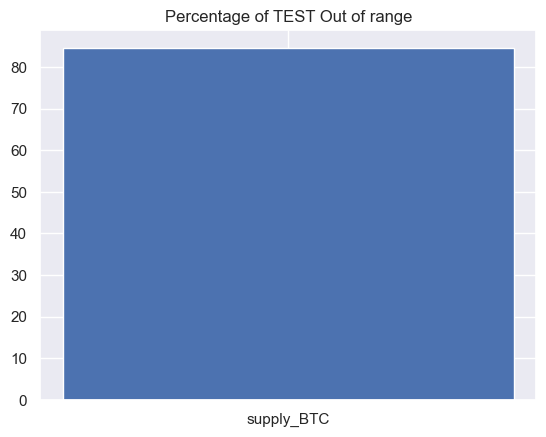

In [91]:
fig, ax = plt.subplots()
ax.bar(df_count_out.xs("pc_out_max").index.tolist(), df_count_out.xs("pc_out_max").values)
ax.bar(df_count_out.xs("pc_out_min").index.tolist(), -df_count_out.xs("pc_out_min").values)
ax.set_title("Percentage of TEST Out of range")

Text(0.5, 1.0, 'Features scaled boxplot')

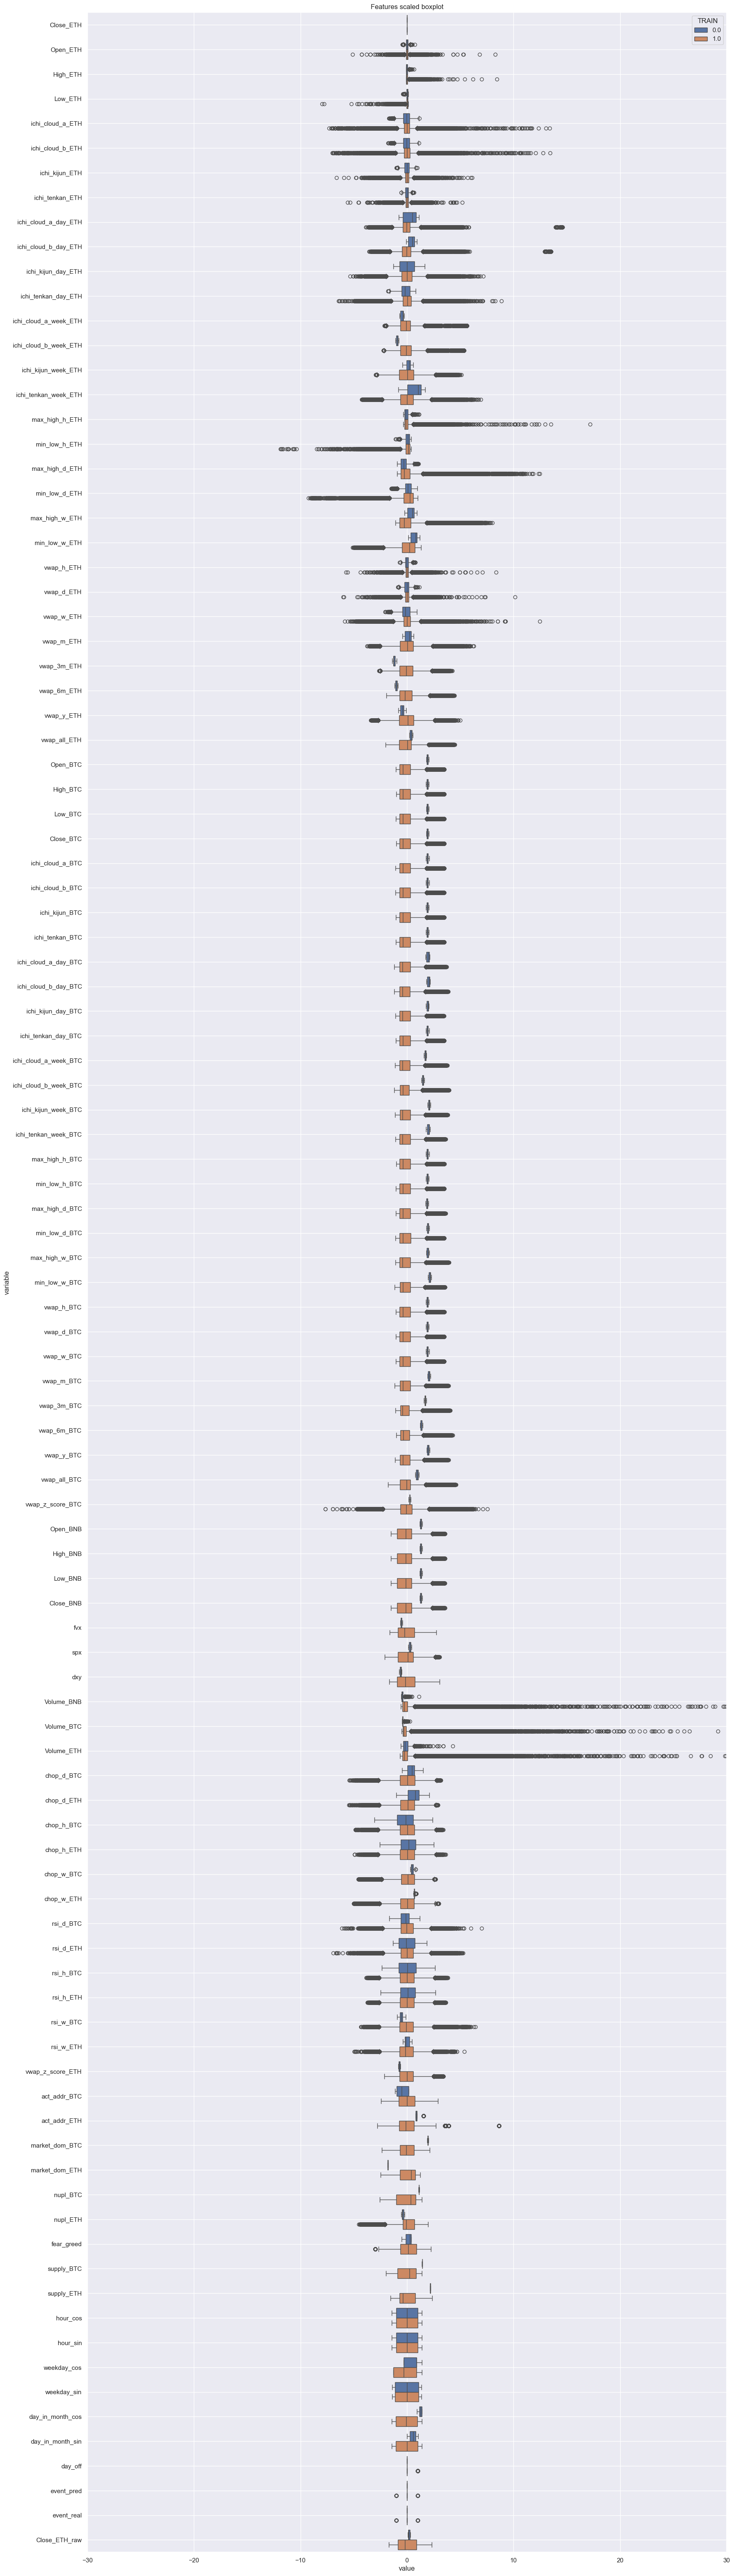

In [92]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

In [93]:
df_comp[(df_comp["TRAIN"] == True) & (df_comp["variable"] == "day_off")]["value"].unique()

array([0., 1.])

In [94]:
df_comp[(df_comp["TRAIN"] == True) & (df_comp["variable"] == "day_off")]["value"].unique()


array([0., 1.])

In [95]:
df_comp[(df_comp["TRAIN"] == False) & (df_comp["variable"] == "day_off")]["value"].unique()

array([0.])

<Axes: >

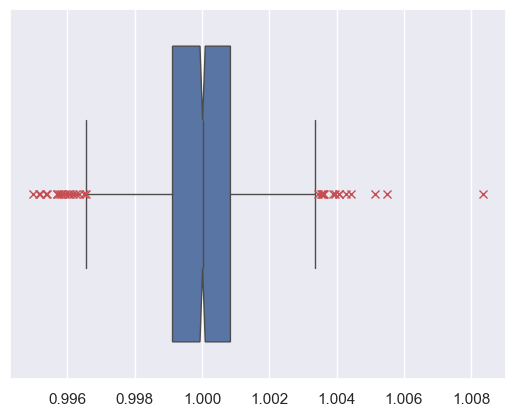

In [96]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_54523/4208190987.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


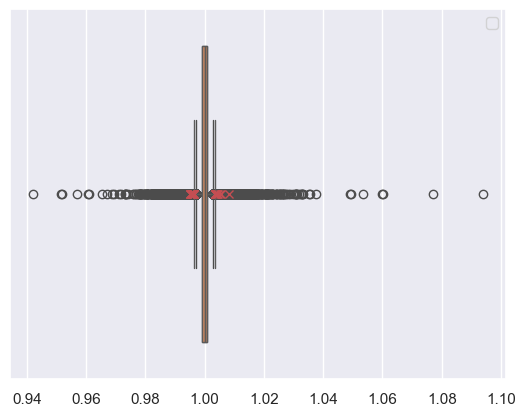

In [97]:
ax = sns.boxplot(
    x=X_train_dat[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

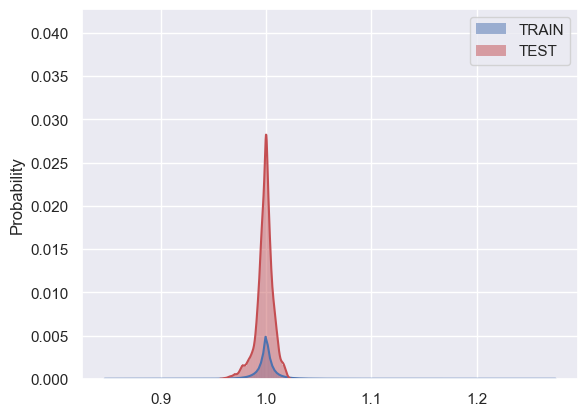

In [98]:

ax = sns.histplot(x=X_train_dat.reshape(-1, X_train_dat.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [99]:
def plot_hist_cat(x, data, title):
    '''
    Plot histogram count of categorical data 
    Add proportional information
    '''
    ser_val = data[x].value_counts(dropna=False)
    pc_val = ser_val.values / data[x].shape[0]

    sns.catplot(x=x, kind="count", palette="ch:.25", data=data, 
                height=5, 
                aspect=1.7,
                order=ser_val.index)
    fig = plt.gcf()
    ax = fig.gca()

    for K, y_val in enumerate(ser_val.values):
        ax.text(K, y_val, '{:.2f}'.format(pc_val[K]))
    
    ax.set_title(title)
    
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    return ser_val

def contingency_table(X, Y, data):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    and p value of independance
    '''
    c = data[[X,Y]].pivot_table(index=X, columns=Y, aggfunc=len)

    c = c.fillna(0) # on remplace les valeurs nulles par des 0

    chi2, p, dof, expected = stats.chi2_contingency(c)

    return c, chi2, p, dof, expected



def plot_cont(X, Y, data, liste_cat=None):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    '''
    c, chi2, p, dof, expected = contingency_table(X, Y, data)
    print("expected: ", expected)
    
    tx = data[X].value_counts()
    ty = data[Y].value_counts()
    
    cont = c.copy()
    cont.loc[:,"Total"] = tx
    cont.loc["total",:] = ty
    cont.loc["total","Total"] = len(data)
    
    print(cont)

    tx = pd.DataFrame(tx)
    ty = pd.DataFrame(ty)
    tx.columns = ["foo"]
    ty.columns = ["foo"]
    n = len(data)
    indep = tx.dot(ty.T) / n
    
    # calcul du signe (add-on)
    d_sign = (c-indep) / np.fabs(c-indep)
    
    mesure = d_sign * (c-indep)**2 / indep
    
    # patch sign
    xi_n = np.fabs(mesure).sum().sum()
    print("xi_n = ", xi_n)
    
    print("chi2: ", chi2)
    print("dof: ", dof)
    print("p: ", p)
    print(f"We have we have a {100*p:.4f}% chance for H0 to be true.")
    print("H0 : independance of distributions")
    print("H1 : distribution are not independant : we reject H0")
    # plot
    #print(c.shape)
    fig = plt.figure(figsize = (7/5*c.shape[1], 6/4*c.shape[0]))
    sns.heatmap(mesure/xi_n, annot=c, fmt=".0f", center=0)
    ax = fig.gca()
    ax.set_title(Y + "= f( " + X + ")")
    plt.show()
    
    return c

In [100]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None, size=25):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (size, size*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

### Linear Corr

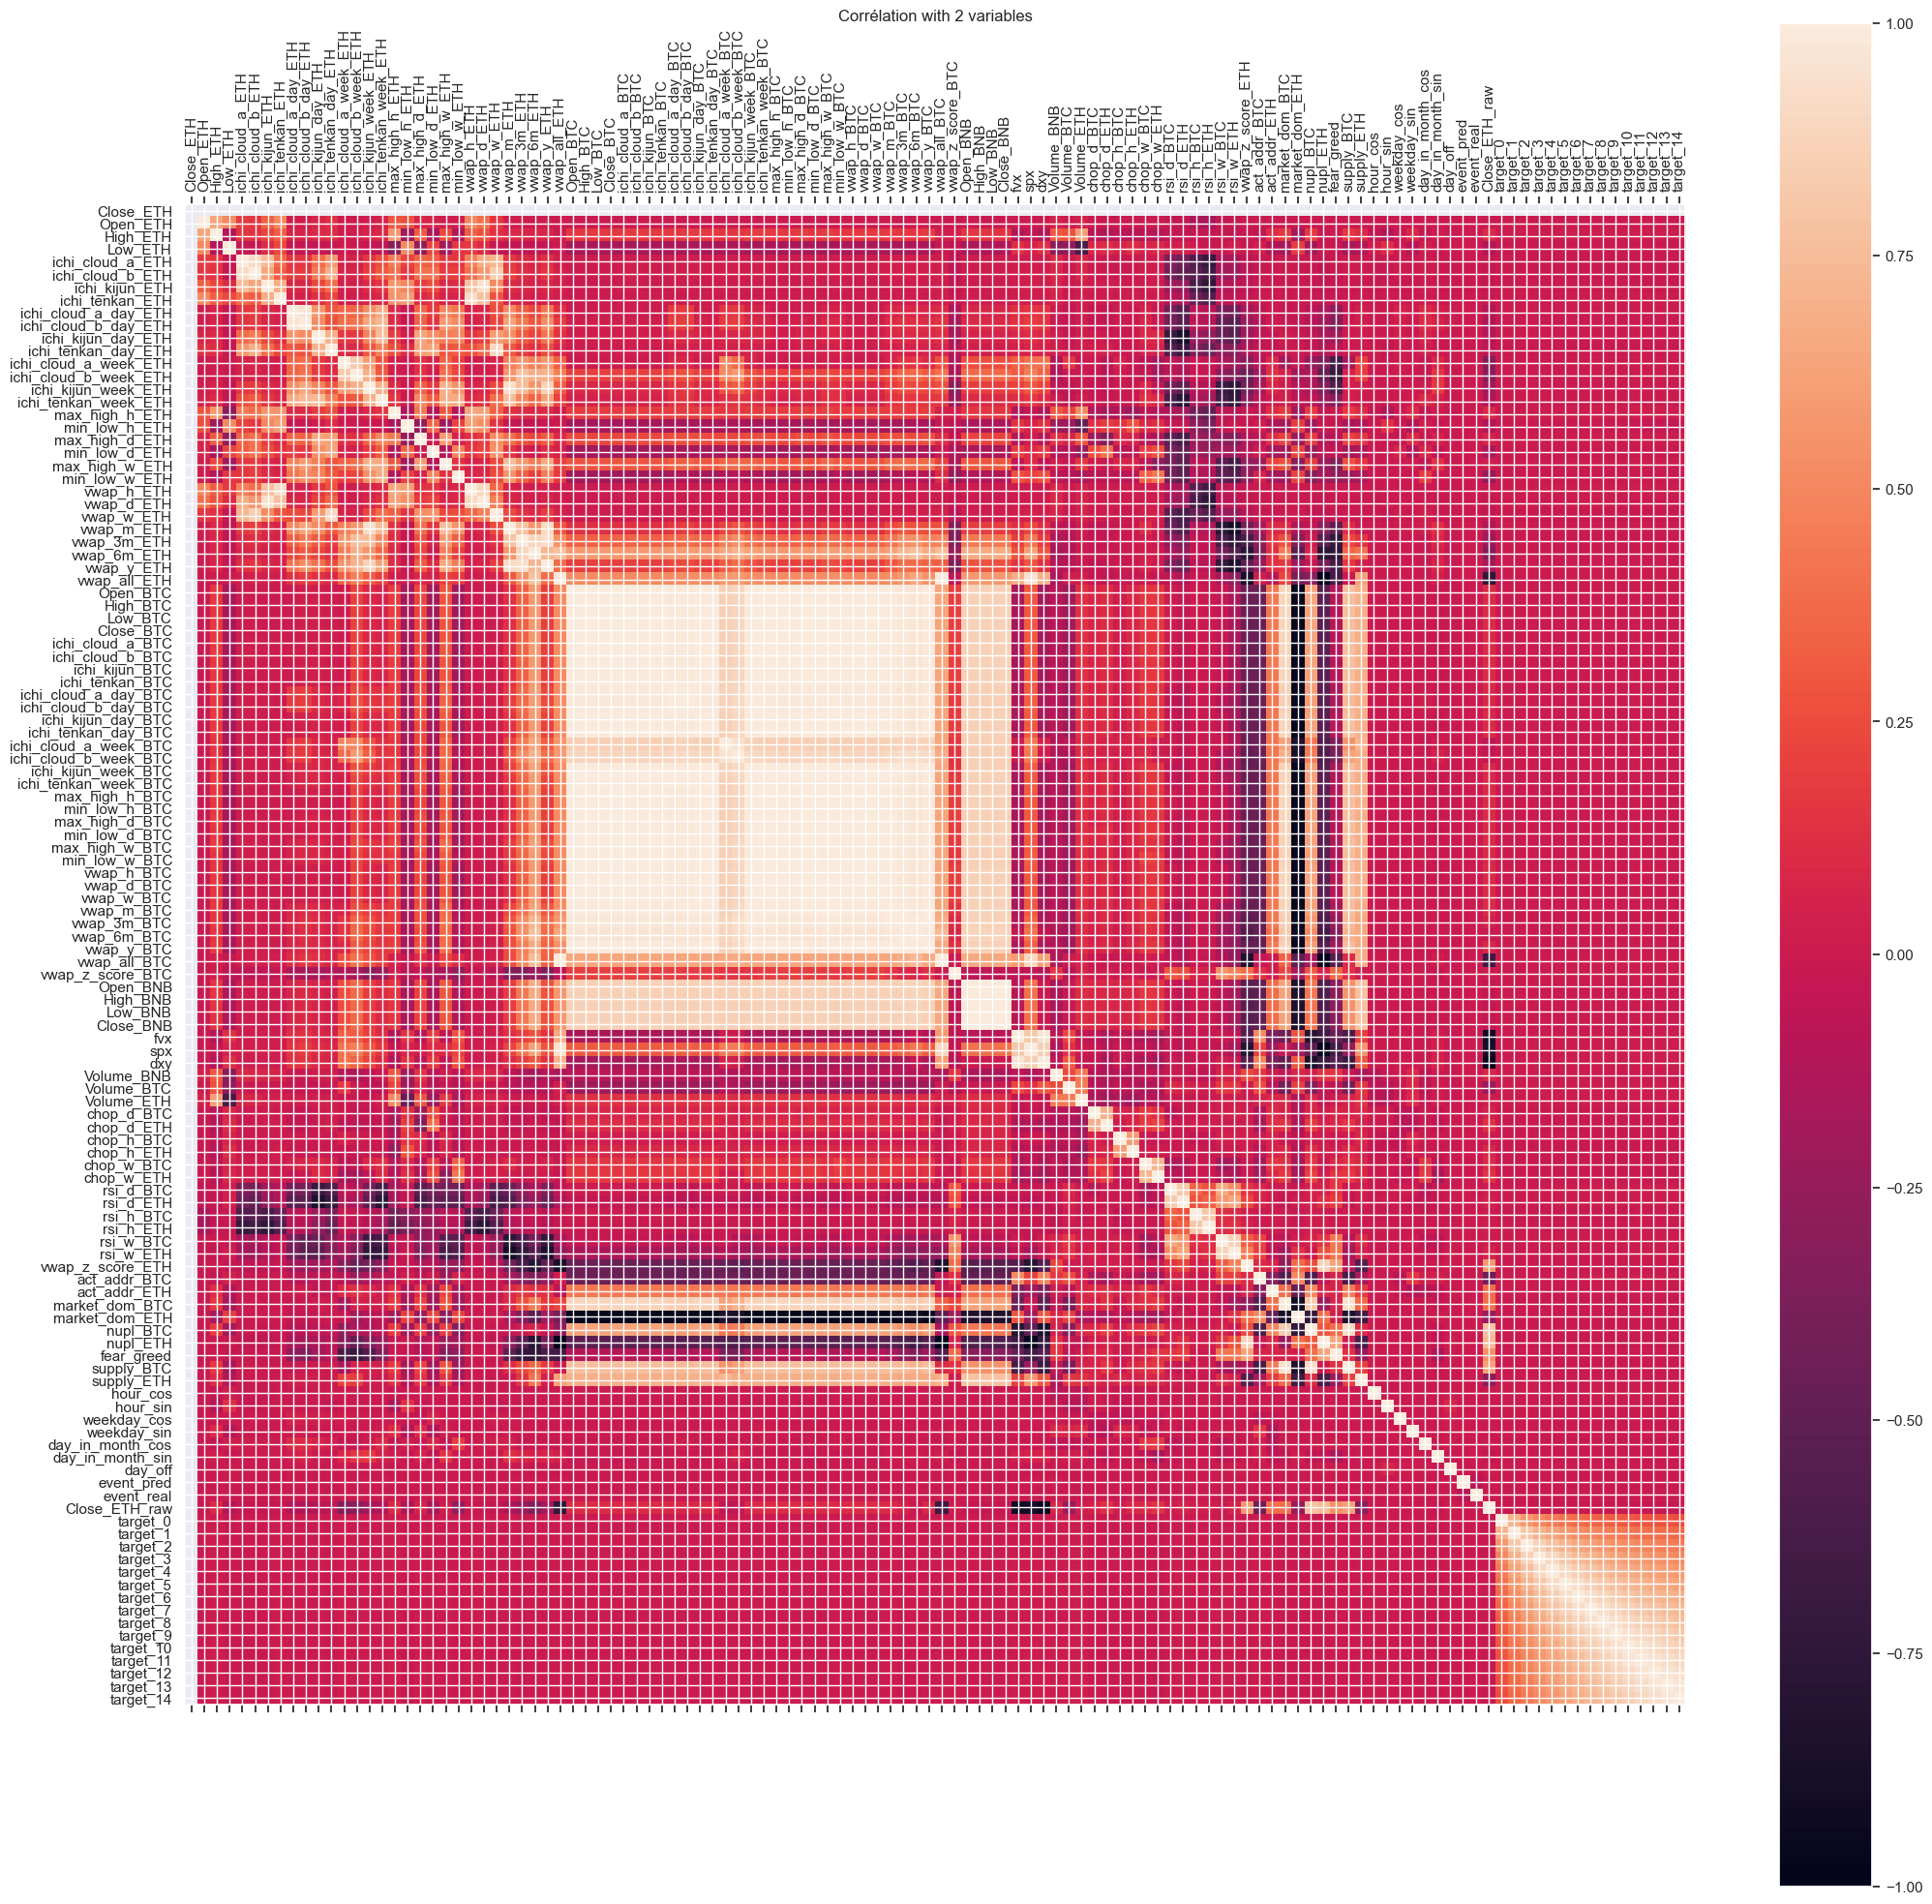

In [101]:
nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_dat[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


In [102]:
y_train.shape

(253677, 15)

In [103]:
list_col_corr

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [104]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [105]:
df.filter(list_col_select)

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0             1.0  0.999782  1.000109  0.999774          0.999171   
1             1.0  0.999548  1.000008  0.999540          0.998785   
2             1.0  1.000084  1.000193  0.999841          0.998860   
3             1.0  1.000770  1.000770  0.999900          0.999669   
4             1.0  0.999330  1.000025  0.999330          0.999178   
...           ...       ...       ...       ...               ...   
253672        1.0  0.998258  1.001698  0.997009          1.009059   
253673        1.0  0.998554  1.001387  0.998451          1.006895   
253674        1.0  1.004900  1.005056  0.999299          1.011829   
253675        1.0  1.001168  1.001491  0.997621          1.011492   
253676        1.0  1.012121  1.014171  0.998487          1.023400   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0               0.999736        0.998393         0.999464   
1               0.999276        0.998113         0.999184   
2               0.999351        0.998243         0.999477   
3               1.000113        0.999003         1.000239   
4               0.999443        0.998335         0.999569   
...                  ...             ...              ...   
253672          1.012239        1.000323         1.000559   
253673          1.010775        0.998877         0.999113   
253674          1.015728        1.003772         1.004009   
253675          1.015731        1.004944         1.003987   
253676          1.028043        1.011526         1.009147   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
0                   2.024261              2.017807  ...  2.588190e-01   
1                   2.023329              2.016878  ...  6.123234e-17   
2                   2.023482              2.017030  ...  6.123234e-17   
3                   2.025023              2.018567  ...  6.123234e-17   
4                   2.023668              2.017215  ...  6.123234e-17   
...                      ...                   ...  ...           ...   
253672              1.043299              1.026564  ...  9.659258e-01   
253673              1.041791              1.025079  ...  9.659258e-01   
253674              1.046896              1.030103  ...  9.659258e-01   
253675              1.048118              1.031306  ...  9.659258e-01   
253676              1.060823              1.043807  ...  9.659258e-01   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
0       0.965926     0.623490    -0.781832           0.97953   
1       1.000000     0.623490    -0.781832           0.97953   
2       1.000000     0.623490    -0.781832           0.97953   
3       1.000000     0.623490    -0.781832           0.97953   
4       1.000000     0.623490    -0.781832           0.97953   
...          ...          ...          ...               ...   
253672  0.258819    -0.222521    -0.974928           1.00000   
253673  0.258819    -0.222521    -0.974928           1.00000   
253674  0.258819    -0.222521    -0.974928           1.00000   
253675  0.258819    -0.222521    -0.974928           1.00000   
253676  0.258819    -0.222521    -0.974928           1.00000   

        day_in_month_sin  day_off  event_pred  event_real  Close_ETH_raw  
0           2.012985e-01      0.0         0.0         0.0    1194.540039  
1           2.012985e-01      0.0         0.0         0.0    1195.089966  
2           2.012985e-01      0.0         0.0         0.0    1195.000000  
3           2.012985e-01      0.0         0.0         0.0    1194.089966  
4           2.012985e-01      0.0         0.0         0.0    1194.890015  
...                  ...      ...         ...         ...            ...  
253672     -2.449294e-16      0.0         0.0         0.0    2520.719971  
253673     -2.449294e-16      0.0         0.0         0.0    2524.370117  
253674     -2.449294e-16      0.0         0.0         0.0    2512.060059  
253675     -2.449294e-16      0.0         0.0     

In [106]:
df.filter(list_col_targets)

target_0  target_1  target_2  target_3  target_4  target_5  target_6  \
0       1.000460  1.000385  0.999623  1.000293  0.999816  1.000050  0.999498   
1       0.999925  0.999163  0.999833  0.999356  0.999590  0.999038  0.999046   
2       0.999238  0.999908  0.999431  0.999665  0.999113  0.999121  0.999473   
3       1.000670  1.000193  1.000427  0.999874  0.999883  1.000234  1.000301   
4       0.999523  0.999757  0.999205  0.999213  0.999565  0.999632  0.999565   
...          ...       ...       ...       ...       ...       ...       ...   
253672  1.001448  0.996564  0.995402  0.983481  0.990876  0.990951  0.988297   
253673  0.995124  0.993963  0.982059  0.989443  0.989518  0.986868  0.986836   
253674  0.998834  0.986871  0.994292  0.994367  0.991704  0.991672  0.992440   
253675  0.988024  0.995453  0.995528  0.992862  0.992830  0.993599  0.991049   
253676  1.007519  1.007596  1.004897  1.004865  1.005643  1.003062  1.010629   

        target_7  target_8  target_9  target_10  target_11  target_12  \
0       0.999506  0.999858  0.999925   0.999858   1.000226   0.999891   
1       0.999398  0.999464  0.999398   0.999766   0.999431   0.999690   
2       0.999540  0.999473  0.999841   0.999506   0.999766   0.999473   
3       1.000234  1.000603  1.000268   1.000528   1.000234   0.999640   
4       0.999933  0.999598  0.999858   0.999565   0.998971   0.998686   
...          ...       ...       ...        ...        ...        ...   
253672  0.988265  0.989031  0.986492   0.993934   0.995977   0.997667   
253673  0.987601  0.985066  0.992497   0.994537   0.996225   0.993384   
253674  0.989893  0.997361  0.999411   1.001107   0.998252   0.997170   
253675  0.998525  1.000578  1.002276   0.999418   0.998334   0.994448   
253676  1.012706  1.014425  1.011533   1.010435   1.006502   1.009294   

        target_13  target_14  
0        1.000151   0.999858  
1        0.999398   0.998803  
2        0.998879   0.998594  
3        0.999355   1.000427  
4        0.999757   0.999732  
...           ...        ...  
253672   0.994823   0.993744  
253673   0.992307   0.988445  
253674   0.993288   0.996043  
253675   0.997206   0.995803  
253676   1.007874   1.007934  

[253677 rows x 15 columns]

In [107]:
df["Close_ETH_raw"].corr(df["target_14"])

np.float64(-0.01767952024837609)

In [108]:
df.filter(list_col_select).corrwith(df["target_14"])

/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Close_ETH                NaN
Open_ETH            0.006258
High_ETH            0.021161
Low_ETH            -0.014519
ichi_cloud_a_ETH   -0.008137
                      ...   
day_in_month_sin   -0.001319
day_off             0.000980
event_pred         -0.002843
event_real          0.000742
Close_ETH_raw      -0.017680
Length: 103, dtype: float64

In [109]:
df.filter(list_col_select).corrwith(df.filter(list_col_targets))

Close_BNB          NaN
Close_BTC          NaN
Close_ETH          NaN
Close_ETH_raw      NaN
High_BNB           NaN
                    ..
vwap_y_ETH         NaN
vwap_z_score_BTC   NaN
vwap_z_score_ETH   NaN
weekday_cos        NaN
weekday_sin        NaN
Length: 118, dtype: float64

In [110]:
len(list_col_select)

103

In [111]:
nb_plot

103

In [112]:
# # to be optimized : 18 min to compute
# list_corr = []
# for I_past in range(PAST_HISTORY):
#     # Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#     df = pd.DataFrame(np.hstack((X_train_dat[:, I_past, :nb_plot], y_train)), 
#         columns=list_col_corr)
#     # Calculer la matrice de corrélation
#     corr_matrix = df.corr()
#     # keep only correlation with targets
#     corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
#     # append dataframe to list
#     list_corr.append(corr_matrix_targets)
# arr_corr_matrix_targets = np.array(list_corr)
# arr_corr_matrix_targets.shape

In [113]:
# Assuming the following variables are pre-defined from your environment:
# PAST_HISTORY: int
# X_train_dat: np.ndarray (e.g., shape: num_samples, total_past_steps, num_total_features)
# y_train: np.ndarray (e.g., shape: num_samples, num_targets or num_samples for single target)
# list_col_select: list of strings (names of all features)
# nb_plot: int (number of features to use from X_train_dat, e.g., list_col_select[:nb_plot])
# list_col_targets: list of strings (names of target columns)
# list_col_corr: list of strings (from original code, not strictly needed for optimized version but was used for column naming in the old approach)

# Optimized code for calculating correlations:
list_corr_optimized = []

# Create a DataFrame for the target(s) once, as it's constant across I_past iterations.
# This assumes y_train has columns corresponding to list_col_targets.
# If y_train is 1D (num_samples,), list_col_targets should contain one target name.
y_train_df = pd.DataFrame(y_train, columns=list_col_targets)

# These are the names of the feature columns we'll be selecting from X_train_dat.
# These will form the row index of our correlation matrix for each I_past.
feature_names_to_correlate = list_col_select[:nb_plot]

for I_past in range(PAST_HISTORY):
    # Extract the relevant feature data for the current I_past step
    # Shape: (num_samples, nb_plot)
    current_X_data = X_train_dat[:, I_past, :nb_plot]
    
    # Create a DataFrame for the features of the current I_past step
    df_features = pd.DataFrame(current_X_data, columns=feature_names_to_correlate)
    
    # Initialize a DataFrame to store correlations for this I_past step
    # Rows: features (feature_names_to_correlate)
    # Columns: targets (list_col_targets)
    # This ensures consistent shape and ordering.
    corr_matrix_for_this_past_step = pd.DataFrame(
        index=feature_names_to_correlate,
        columns=list_col_targets,
        dtype=float  # Ensure float type for correlations
    )
    
    # Calculate correlation of all features with each target column
    for target_col_name in list_col_targets:
        # df_features.corrwith() computes the correlation of each column in df_features
        # with the provided Series (y_train_df[target_col_name]).
        # The result is a Series indexed by feature_names_to_correlate.
        corrs_with_target = df_features.corrwith(y_train_df[target_col_name])
        corr_matrix_for_this_past_step[target_col_name] = corrs_with_target
            
    list_corr_optimized.append(corr_matrix_for_this_past_step)

# Convert the list of DataFrames to a 3D NumPy array
# Each DataFrame in list_corr_optimized has shape (len_feat, len_targets)
# So, arr_corr_matrix_targets will have shape (PAST_HISTORY, len_feat, len_targets)
# The final variable name 'arr_corr_matrix_targets' matches the original script's output.
arr_corr_matrix_targets = np.array([df.values for df in list_corr_optimized])

# To check the shape (optional, similar to original script's last line intent):
print(arr_corr_matrix_targets.shape)

/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(72, 103, 15)


In [114]:
min_corr = np.min(arr_corr_matrix_targets, axis=0)
# create a same col/row thatn corr_matrix_targets  dataframe using the array max_corr 
min_corr_matrix_targets = pd.DataFrame(min_corr, columns=list_col_targets, index=feature_names_to_correlate)
min_corr_matrix_targets

target_0  target_1  target_2  target_3  target_4  target_5  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH         -0.001701 -0.002949 -0.004338 -0.004786 -0.005536 -0.006069   
High_ETH         -0.000797 -0.002178 -0.003831 -0.004392 -0.004896 -0.005219   
Low_ETH          -0.016817 -0.009355 -0.013130 -0.010434 -0.012921 -0.014196   
ichi_cloud_a_ETH -0.001333 -0.002698 -0.004206 -0.004785 -0.005420 -0.005741   
...                    ...       ...       ...       ...       ...       ...   
day_in_month_sin -0.000398 -0.000557 -0.000692 -0.000797 -0.000877 -0.000949   
day_off          -0.001658 -0.001925 -0.002138 -0.002449 -0.002720 -0.002928   
event_pred       -0.007535 -0.007502 -0.007099 -0.006575 -0.007400 -0.007414   
event_real       -0.006934 -0.005017 -0.006066 -0.006793 -0.007159 -0.006455   
Close_ETH_raw    -0.004679 -0.006619 -0.008133 -0.009389 -0.010496 -0.011500   

                  target_6  target_7  target_8  target_9  target_10  \
Close_ETH              NaN       NaN       NaN       NaN        NaN   
Open_ETH         -0.006341 -0.006946 -0.007559 -0.008070  -0.008769   
High_ETH         -0.005530 -0.006099 -0.006690 -0.007125  -0.007764   
Low_ETH          -0.012469 -0.012652 -0.013120 -0.012089  -0.012053   
ichi_cloud_a_ETH -0.006049 -0.006704 -0.007392 -0.007962  -0.008725   
...                    ...       ...       ...       ...        ...   
day_in_month_sin -0.001011 -0.001072 -0.001131 -0.001170  -0.001207   
day_off          -0.002984 -0.003063 -0.003417 -0.003756  -0.004137   
event_pred       -0.008150 -0.008197 -0.007157 -0.007306  -0.006725   
event_real       -0.006324 -0.005582 -0.005122 -0.005386  -0.005777   
Close_ETH_raw    -0.012413 -0.013273 -0.014083 -0.014851  -0.015591   

                  target_11  target_12  target_13  target_14  
Close_ETH               NaN        NaN        NaN        NaN  
Open_ETH          -0.009670  -0.010539  -0.011152  -0.011719  
High_ETH          -0.008598  -0.009396  -0.010045  -0.010533  
Low_ETH           -0.012555  -0.013287  -0.014501  -0.014519  
ichi_cloud_a_ETH  -0.009675  -0.010512  -0.011161  -0.011769  
...                     ...        ...        ...        ...  
day_in_month_sin  -0.001238  -0.001268  -0.001295  -0.001330  
day_off           -0.004513  -0.004813  -0.004936  -0.004976  
event_pred        -0.006705  -0.006893  -0.006448  -0.006236  
event_real        -0.005484  -0.005540  -0.005085  -0.005007  
Close_ETH_raw     -0.016306  -0.016993  -0.017642  -0.018262  

[103 rows x 15 columns]

In [115]:
max_corr = np.max(arr_corr_matrix_targets, axis=0)
# create a same col/row thatn corr_matrix_targets  dataframe using the array max_corr 
max_corr_matrix_targets = pd.DataFrame(max_corr, columns=list_col_targets, index=feature_names_to_correlate)
max_corr_matrix_targets

target_0  target_1  target_2  target_3  target_4  target_5  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH          0.012652  0.012706  0.007384  0.008588  0.009448  0.010770   
High_ETH          0.014405  0.018180  0.013382  0.014009  0.015279  0.018274   
Low_ETH           0.009441  0.007320  0.005701  0.006453  0.007151  0.007921   
ichi_cloud_a_ETH  0.001506  0.000691 -0.000851 -0.001260 -0.001769 -0.002025   
...                    ...       ...       ...       ...       ...       ...   
day_in_month_sin -0.000037 -0.000059 -0.000090 -0.000110 -0.000128 -0.000139   
day_off           0.004958  0.006637  0.008144  0.009304  0.010308  0.011129   
event_pred        0.006938  0.005788  0.004485  0.004810  0.004764  0.005232   
event_real        0.011923  0.007592  0.006667  0.005395  0.004392  0.004200   
Close_ETH_raw    -0.004416 -0.006272 -0.007722 -0.008909 -0.009972 -0.010923   

                  target_6  target_7  target_8  target_9  target_10  \
Close_ETH              NaN       NaN       NaN       NaN        NaN   
Open_ETH          0.011687  0.012110  0.012257  0.012759   0.012753   
High_ETH          0.017810  0.018056  0.017313  0.018760   0.019101   
Low_ETH           0.008671  0.008909  0.008904  0.009035   0.008812   
ichi_cloud_a_ETH -0.002226 -0.003052 -0.003963 -0.004472  -0.005133   
...                    ...       ...       ...       ...        ...   
day_in_month_sin -0.000152 -0.000167 -0.000178 -0.000191  -0.000202   
day_off           0.011804  0.012297  0.012856  0.013461   0.014119   
event_pred        0.005445  0.004738  0.004550  0.004258   0.003870   
event_real        0.003522  0.003433  0.003092  0.002819   0.003152   
Close_ETH_raw    -0.011811 -0.012650 -0.013433 -0.014165  -0.014874   

                  target_11  target_12  target_13  target_14  
Close_ETH               NaN        NaN        NaN        NaN  
Open_ETH           0.011976   0.011651   0.011450   0.011046  
High_ETH           0.019312   0.019143   0.019121   0.021161  
Low_ETH            0.007964   0.007265   0.006881   0.006597  
ichi_cloud_a_ETH  -0.006133  -0.006962  -0.007598  -0.008137  
...                     ...        ...        ...        ...  
day_in_month_sin  -0.000216  -0.000219  -0.000213  -0.000205  
day_off            0.014685   0.015103   0.015379   0.015643  
event_pred         0.003168   0.003361   0.003661   0.003109  
event_real         0.002568   0.003172   0.002769   0.002828  
Close_ETH_raw     -0.015564  -0.016217  -0.016848  -0.017458  

[103 rows x 15 columns]

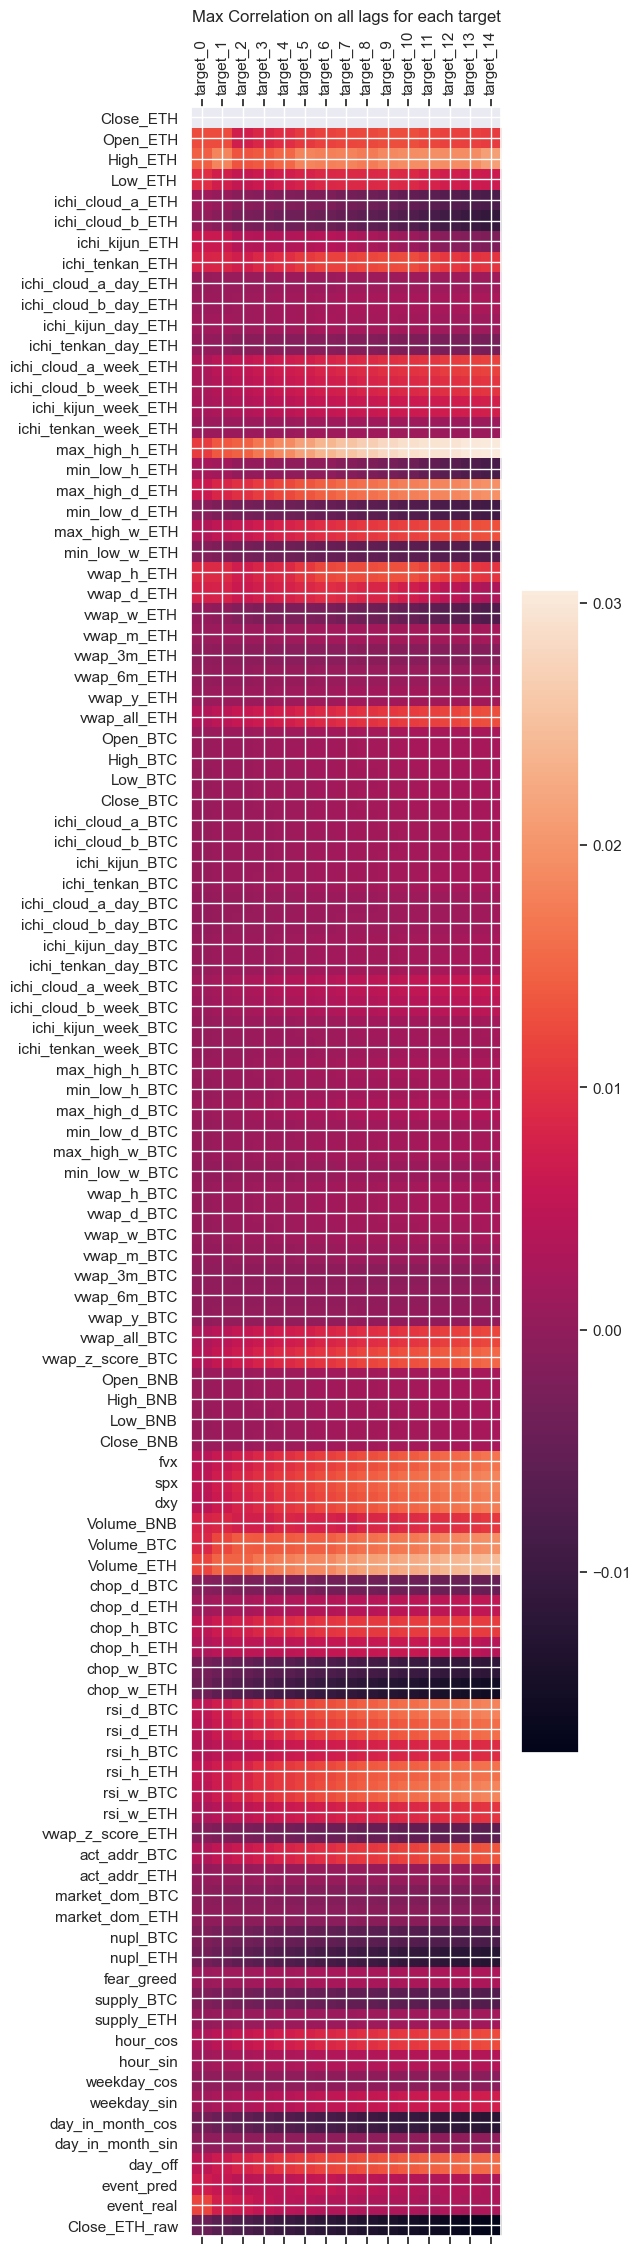

In [116]:
#corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(max_corr_matrix_targets, title = "Max Correlation on all lags for each target", size=5)

In [117]:
arr_corr_matrix_targets.shape

(72, 103, 15)

In [118]:

# create a same col/row thatn corr_matrix_targets  dataframe using the array max_corr 
corr_matrix_targets = pd.DataFrame(arr_corr_matrix_targets[-1,:,:], columns=list_col_targets, index=feature_names_to_correlate)
corr_matrix_targets

target_0  target_1  target_2  target_3  target_4  target_5  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH          0.009073  0.012706  0.005011  0.005306  0.003014  0.002964   
High_ETH          0.014071  0.018180  0.013382  0.014009  0.015279  0.018274   
Low_ETH          -0.016817 -0.009355 -0.013130 -0.010434 -0.012921 -0.014196   
ichi_cloud_a_ETH  0.001506  0.000691 -0.000851 -0.001260 -0.001769 -0.002025   
...                    ...       ...       ...       ...       ...       ...   
day_in_month_sin -0.000296 -0.000423 -0.000544 -0.000668 -0.000773 -0.000863   
day_off           0.001504  0.001980  0.002029  0.002108  0.002348  0.002265   
event_pred       -0.001765 -0.002056 -0.004927 -0.006495 -0.006435 -0.004693   
event_real       -0.000192 -0.000444 -0.000892 -0.000309 -0.000999  0.001766   
Close_ETH_raw    -0.004584 -0.006471 -0.007914 -0.009142 -0.010221 -0.011200   

                  target_6  target_7  target_8  target_9  target_10  \
Close_ETH              NaN       NaN       NaN       NaN        NaN   
Open_ETH          0.005411  0.006158  0.005031  0.005796   0.007312   
High_ETH          0.017810  0.018056  0.017313  0.018760   0.019101   
Low_ETH          -0.012469 -0.012652 -0.013120 -0.012089  -0.012053   
ichi_cloud_a_ETH -0.002226 -0.003052 -0.003963 -0.004472  -0.005133   
...                    ...       ...       ...       ...        ...   
day_in_month_sin -0.000939 -0.001006 -0.001069 -0.001122  -0.001173   
day_off           0.002448  0.002551  0.002508  0.002349   0.002198   
event_pred       -0.005406 -0.006106 -0.004600 -0.004791  -0.004072   
event_real        0.002126  0.000963  0.001933  0.001213   0.000671   
Close_ETH_raw    -0.012098 -0.012931 -0.013712 -0.014452  -0.015153   

                  target_11  target_12  target_13  target_14  
Close_ETH               NaN        NaN        NaN        NaN  
Open_ETH           0.006586   0.005397   0.005068   0.006258  
High_ETH           0.019312   0.019143   0.019121   0.021161  
Low_ETH           -0.012555  -0.013287  -0.014501  -0.014519  
ichi_cloud_a_ETH  -0.006133  -0.006962  -0.007598  -0.008137  
...                     ...        ...        ...        ...  
day_in_month_sin  -0.001227  -0.001266  -0.001291  -0.001319  
day_off            0.002044   0.001500   0.001213   0.000980  
event_pred        -0.003568  -0.003976  -0.004773  -0.002843  
event_real         0.000769   0.001015   0.000718   0.000742  
Close_ETH_raw     -0.015822  -0.016463  -0.017082  -0.017680  

[103 rows x 15 columns]

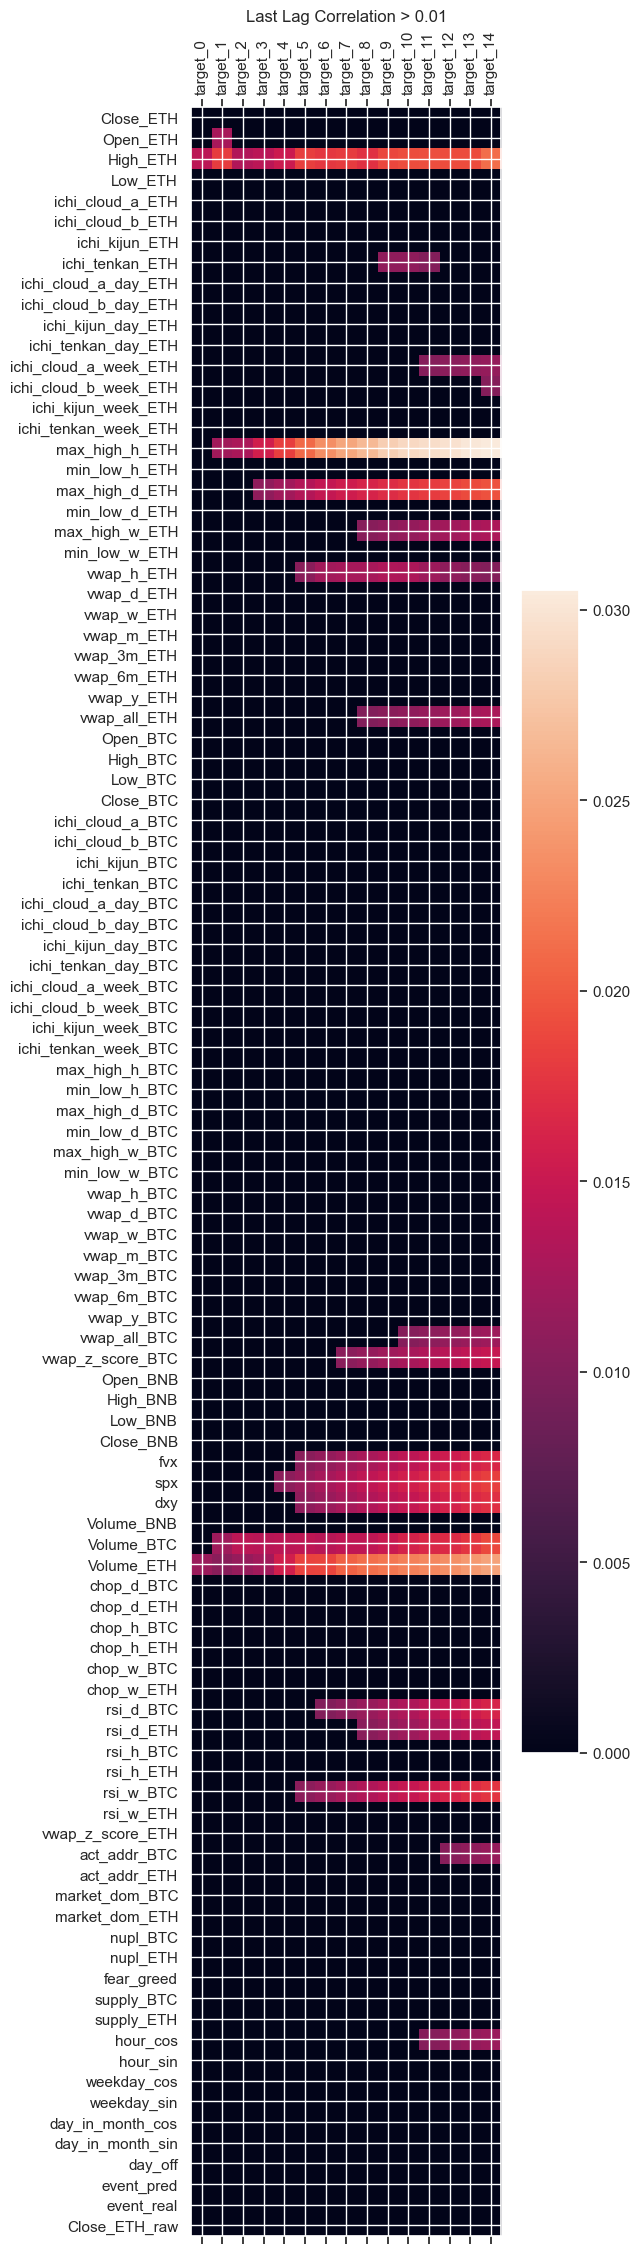

In [119]:
fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets>0.01, 0), 
    title = "Last Lag Correlation > 0.01", 
    size=5)

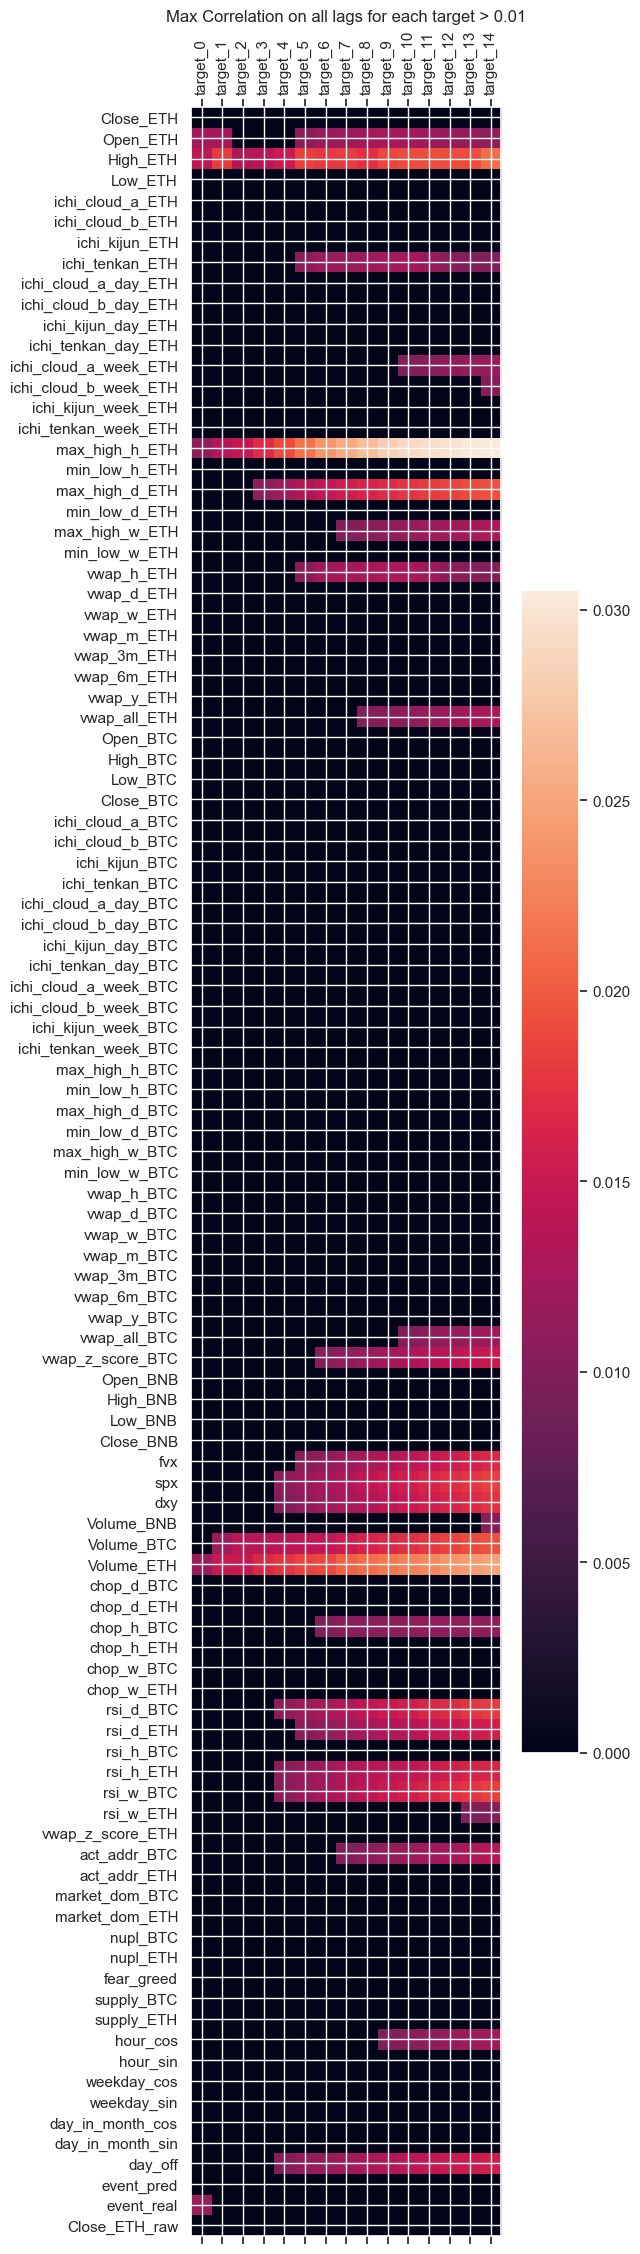

In [120]:
fig = plot_corr(
    max_corr_matrix_targets.where(max_corr_matrix_targets>0.01, 0),
    title="Max Correlation on all lags for each target > 0.01",
    size=5)

<Axes: >

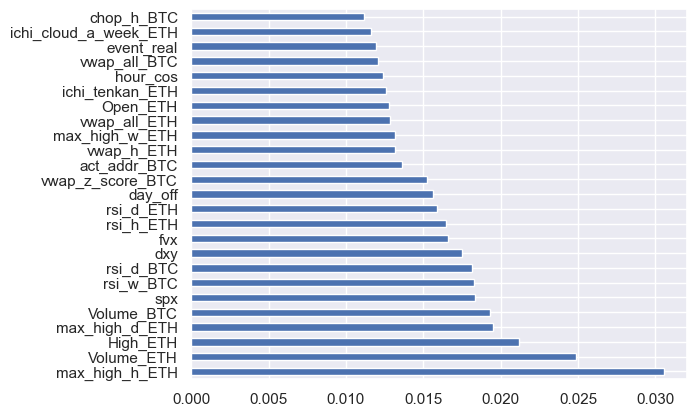

In [121]:
max_max_corr = max_corr_matrix_targets.max(axis=1).sort_values(ascending=False)
max_max_corr[max_max_corr.values>0.011].plot.barh()

#### Test on the highest corr


In [122]:
df = pd.DataFrame(np.hstack((X_train_dat[:, -1, :nb_plot], y_train)), 
        columns=list_col_corr)

In [123]:
df["target_cat"] = "neutral"
df.loc[df["target_14"] >= 1 + 0.5/100, "target_cat"] = "up"
df.loc[df["target_14"] <= 1 - 0.5/100, "target_cat"] = "down"
df["target_cat"].value_counts()

target_cat
neutral    181927
up          36606
down        35144
Name: count, dtype: int64

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_54523/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


target_cat
neutral    181927
up          36606
down        35144
Name: count, dtype: int64

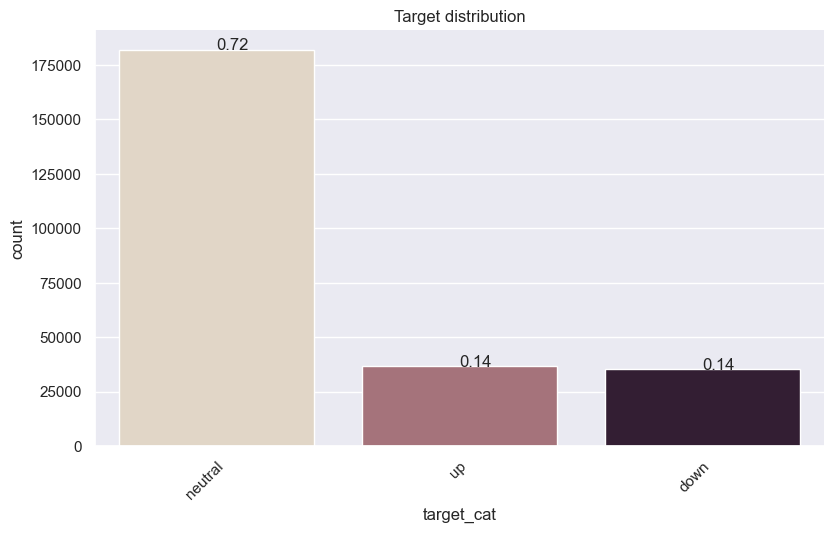

In [124]:
plot_hist_cat("target_cat", df, "Target distribution")

In [125]:
list_level=["neutral", "higher", "very-higher"]
df["max_high_h_ETH_cat"] = "very-higher"
df.loc[df["max_high_h_ETH"] <= 1.01, "max_high_h_ETH_cat"] = "higher"
df.loc[df["max_high_h_ETH"] <= 1.005, "max_high_h_ETH_cat"] = "neutral"

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_54523/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


max_high_h_ETH_cat
neutral        179399
higher          50855
very-higher     23423
Name: count, dtype: int64

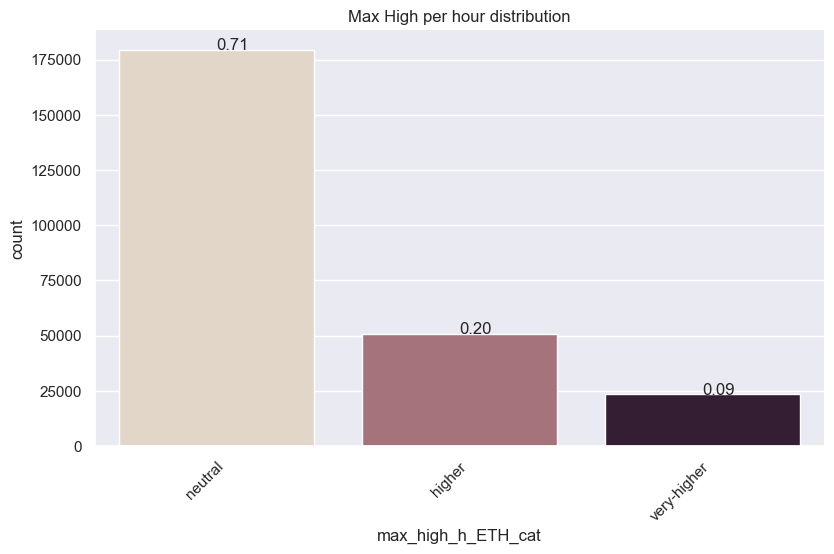

In [126]:
plot_hist_cat("max_high_h_ETH_cat", df, "Max High per hour distribution")

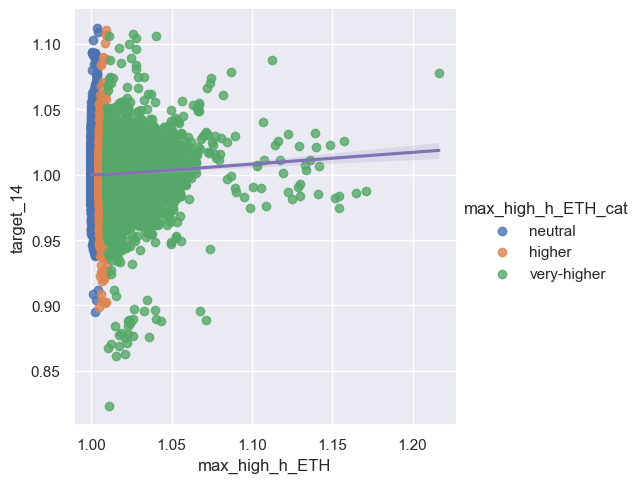

In [127]:
sns.lmplot(x="max_high_h_ETH", y="target_14",
            hue="max_high_h_ETH_cat", data=df,
           line_kws={"color": "C4"})

(0.98, 1.02)

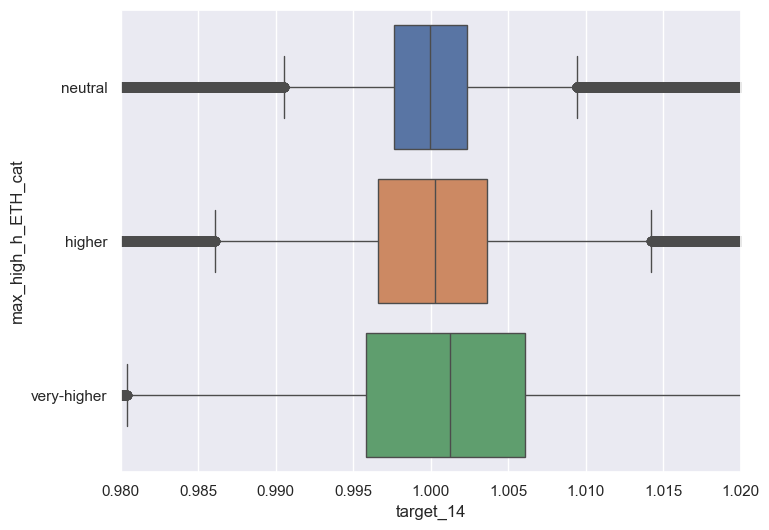

In [128]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="target_14", y="max_high_h_ETH_cat", 
    hue="max_high_h_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])  

expected:  [[  7045.36918995  36471.17233726   7338.45847278]
 [ 24853.64639285 128657.78873528  25887.56487186]
 [  3244.98441719  16798.03892745   3379.97665535]]
target_cat             down   neutral       up     Total
max_high_h_ETH_cat                                      
higher               9130.0   32532.0   9193.0   50855.0
neutral             20774.0  138189.0  20436.0  179399.0
very-higher          5240.0   11206.0   6977.0   23423.0
total               35144.0  181927.0  36606.0  253677.0
xi_n =  10950.84585392982
chi2:  10950.84585392982
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


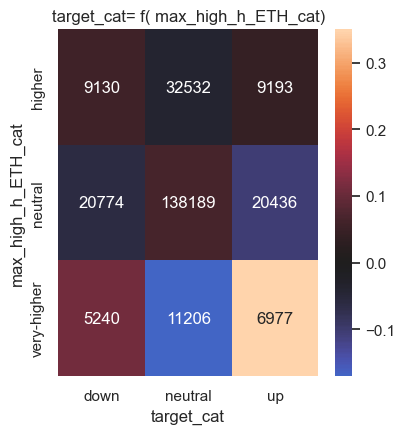

target_cat           down  neutral     up
max_high_h_ETH_cat                       
higher               9130    32532   9193
neutral             20774   138189  20436
very-higher          5240    11206   6977

In [129]:
plot_cont(X="max_high_h_ETH_cat", Y="target_cat", data=df)

expected:  [[  7045.36918995  36471.17233726   7338.45847278]
 [ 24853.64639285 128657.78873528  25887.56487186]
 [  3244.98441719  16798.03892745   3379.97665535]]
target_cat             down   neutral       up     Total
max_high_h_ETH_cat                                      
higher               9130.0   32532.0   9193.0   50855.0
neutral             20774.0  138189.0  20436.0  179399.0
very-higher          5240.0   11206.0   6977.0   23423.0
total               35144.0  181927.0  36606.0  253677.0
xi_n =  10950.84585392982
chi2:  10950.84585392982
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


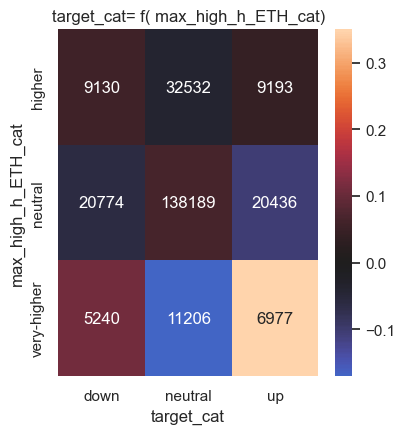

target_cat           down  neutral     up
max_high_h_ETH_cat                       
higher               9130    32532   9193
neutral             20774   138189  20436
very-higher          5240    11206   6977

In [130]:
plot_cont(X="max_high_h_ETH_cat", Y="target_cat", data=df)

In [131]:
df["nupl_ETH"].describe()

count    253677.000000
mean          0.118971
std           0.198094
min          -0.775319
25%           0.039797
50%           0.106898
75%           0.260524
max           0.513805
Name: nupl_ETH, dtype: float64

In [132]:

mquantiles(df["nupl_ETH"], prob=[0.10, 0.90])

array([-0.08284051,  0.36014272])

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_54523/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


nupl_ETH_cat
neutral    168456
higher      69777
lower       15444
Name: count, dtype: int64

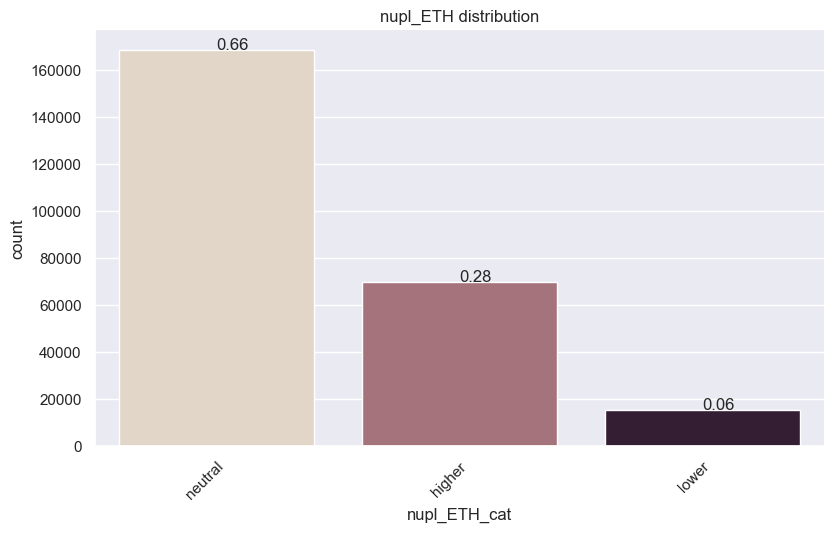

In [133]:

list_level=["lower", "neutral", "higher"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] >= 0.25, "nupl_ETH_cat"] = "higher"
df.loc[df["nupl_ETH"] <= -0.25, "nupl_ETH_cat"] = "lower"
plot_hist_cat("nupl_ETH_cat", df, "nupl_ETH distribution")

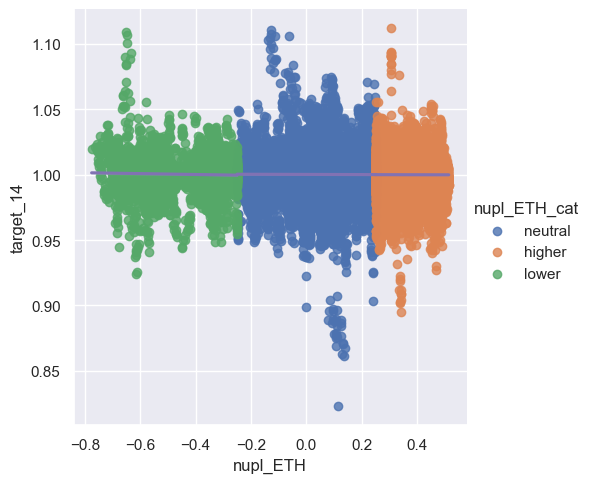

In [134]:
sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})

(0.98, 1.02)

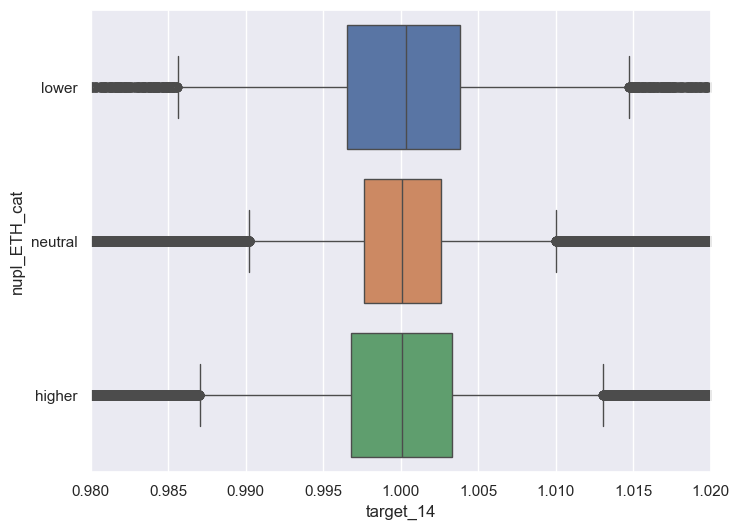

In [135]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])  

expected:  [[  9666.79236982  50041.27405717  10068.93357301]
 [  2139.58670278  11075.81920316   2228.59409406]
 [ 23337.6209274  120809.90673967  24308.47233293]]
target_cat       down   neutral       up     Total
nupl_ETH_cat                                      
higher        11586.0   46564.0  11627.0   69777.0
lower          2817.0    9702.0   2925.0   15444.0
neutral       20741.0  125661.0  22054.0  168456.0
total         35144.0  181927.0  36606.0  253677.0
xi_n =  2159.047419759374
chi2:  2159.047419759374
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


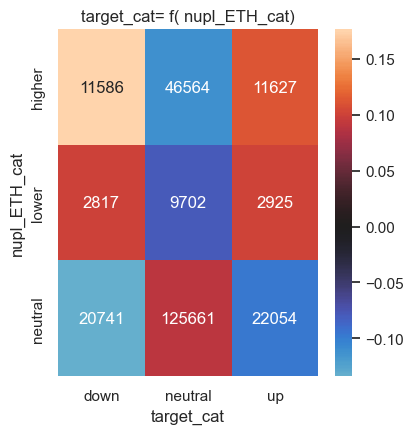

target_cat     down  neutral     up
nupl_ETH_cat                       
higher        11586    46564  11627
lower          2817     9702   2925
neutral       20741   125661  22054

In [136]:
plot_cont(X="nupl_ETH_cat", Y="target_cat", data=df)

In [137]:
chi2 = 2159
indep = 35144.0/253677.0*69777.0
c = 11586
print("chi2: ", chi2)
print("indep: ", indep)
print("c: ", c)
print("chi2 abs part : ", (c-indep)**2/indep)
print("chi2 sign part : ", (c-indep) / np.fabs(c-indep))
print("% of chi2 : ", 100*(c-indep)**2/indep / chi2)


chi2:  2159
indep:  9666.79236982462
c:  11586
chi2 abs part :  381.03207215054994
chi2 sign part :  1.0
% of chi2 :  17.64854433305002


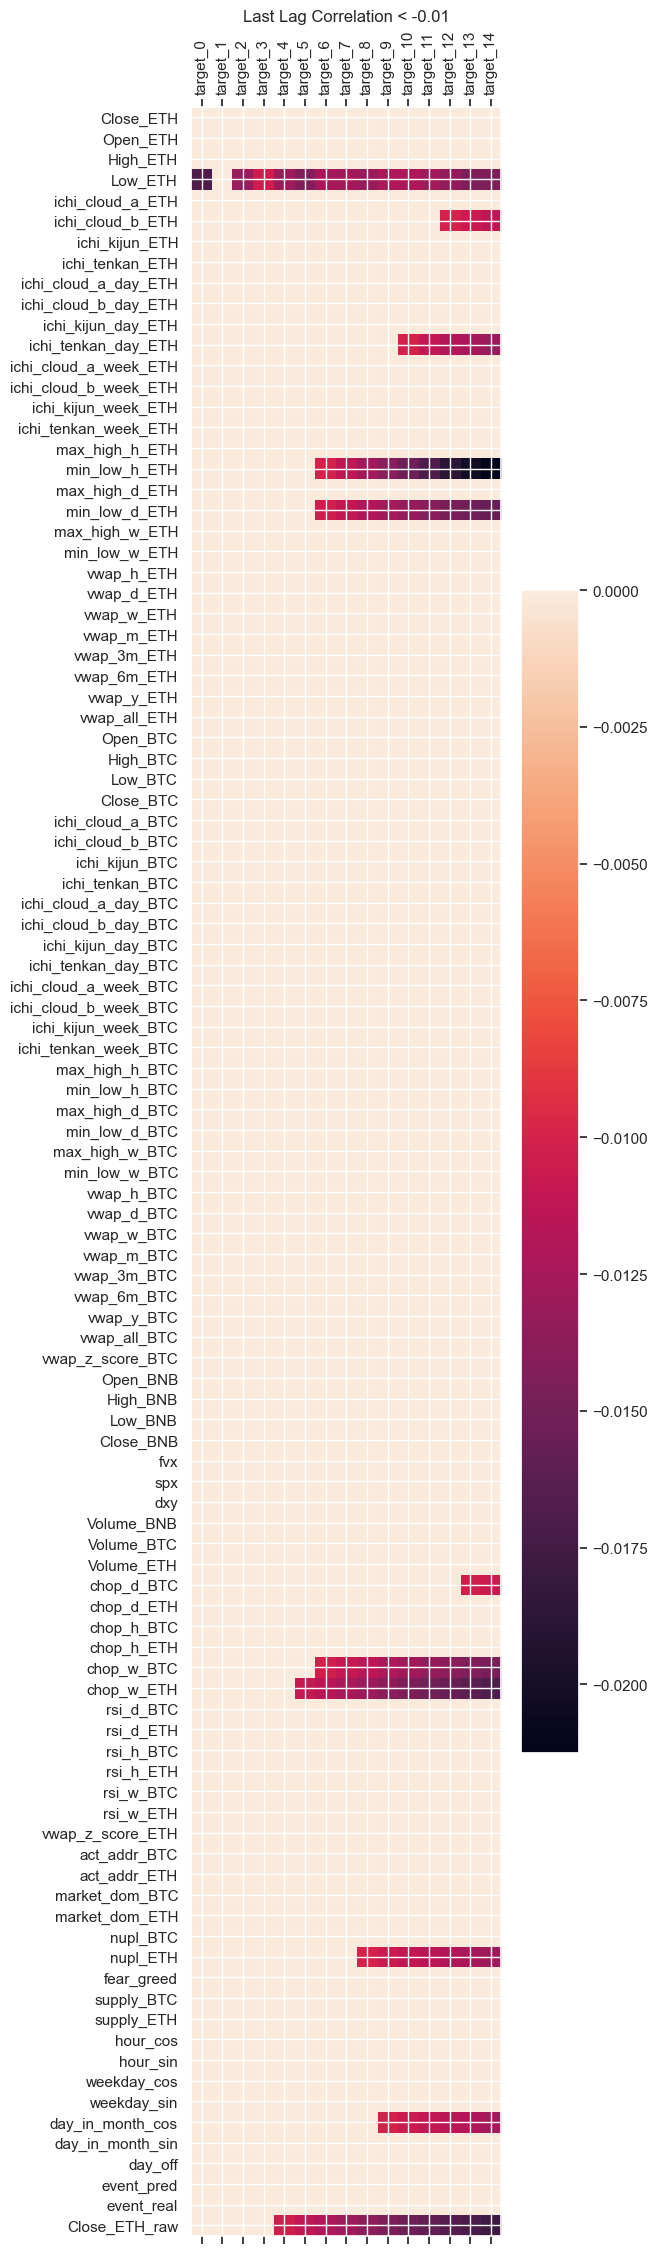

In [138]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.01, 0), 
          title="Last Lag Correlation < -0.01", 
          size=5)

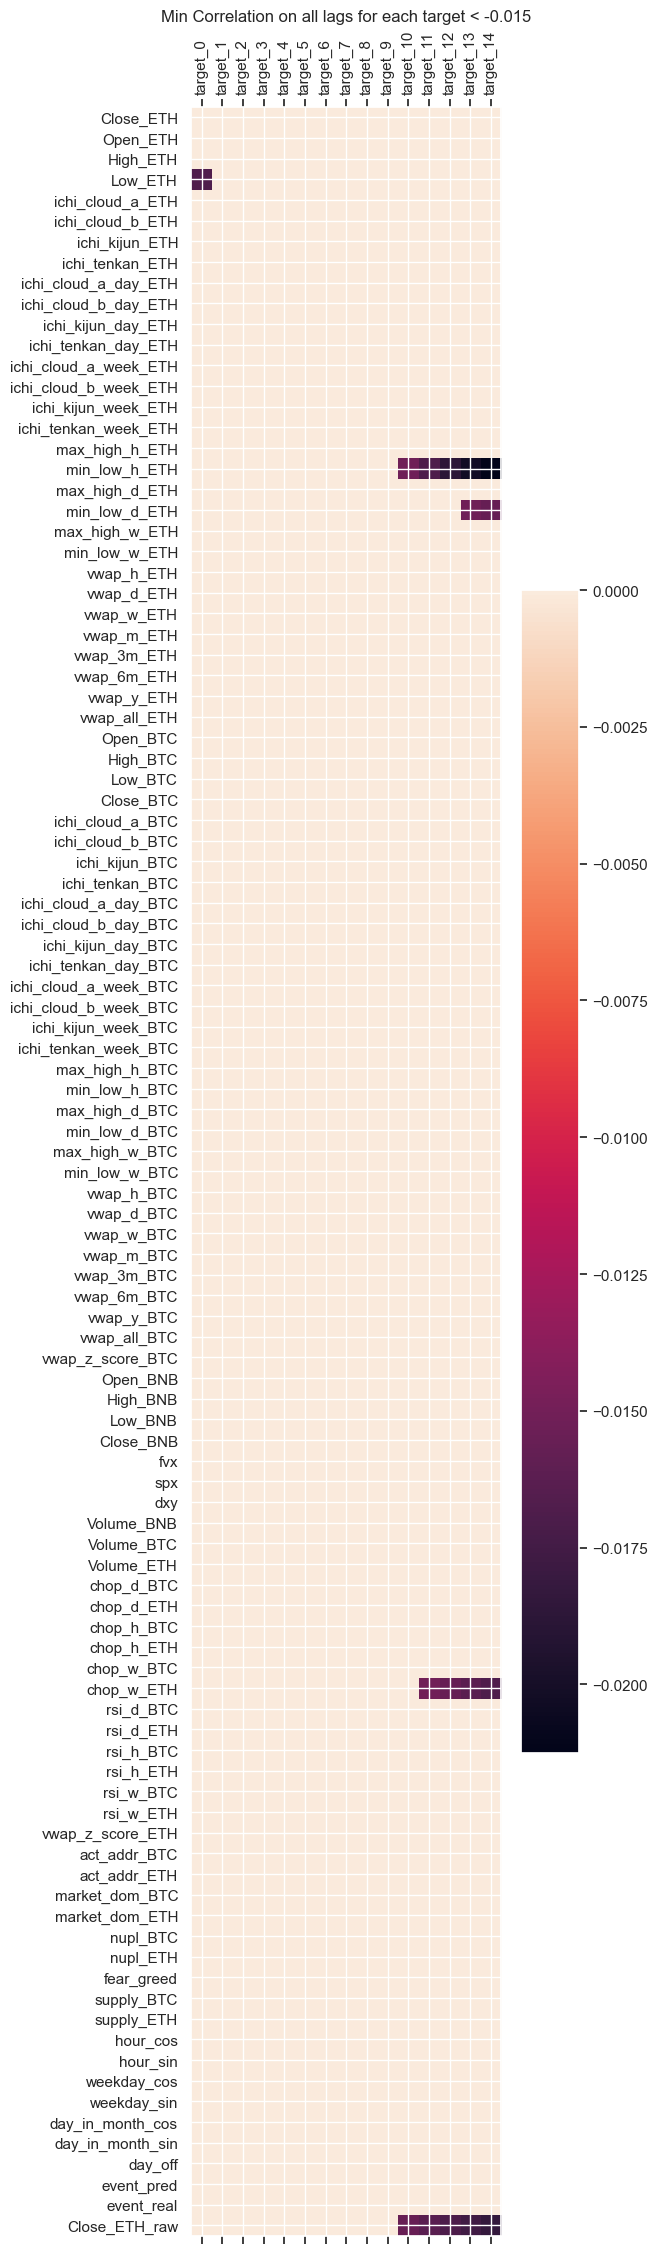

In [139]:
fig = plot_corr(min_corr_matrix_targets.where(min_corr_matrix_targets < -0.015, 0),
                title="Min Correlation on all lags for each target < -0.015",
                size=5)

Text(0, 0.5, 'Min Correlation on all lags for each target < -0.015')

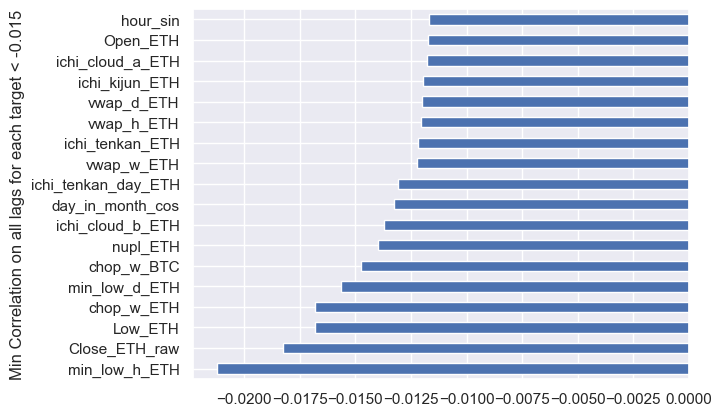

In [140]:
min_min_corr = min_corr_matrix_targets.min(axis=1).sort_values(ascending=True)
min_min_corr[min_min_corr.values<-0.011].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_ylabel("Min Correlation on all lags for each target < -0.015")

<Axes: >

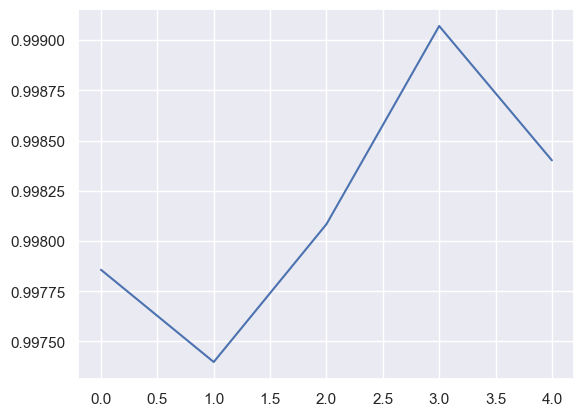

In [141]:
df["min_low_h_ETH"].head().plot()

In [142]:
df["min_low_h_ETH"].describe()

count    253677.000000
mean          0.995225
std           0.005330
min           0.847357
25%           0.993900
50%           0.996677
75%           0.998391
max           1.000000
Name: min_low_h_ETH, dtype: float64

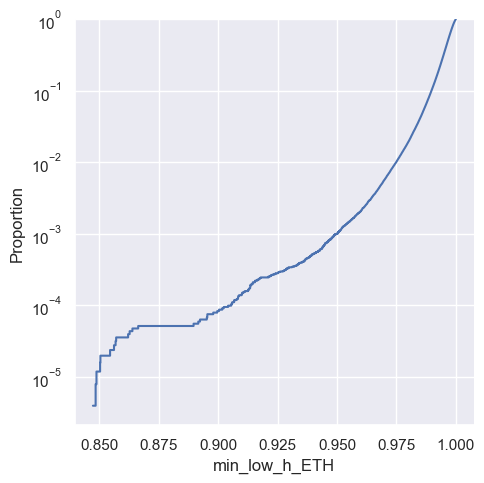

In [143]:
sns.displot(df, x="min_low_h_ETH", kind="ecdf", log_scale=(False, True))

In [144]:
list_level=["very_low", "low", "neutral"]
df["min_low_h_ETH_cat"] = "low"
df.loc[df["min_low_h_ETH"] < 0.995, "min_low_h_ETH_cat"] = "very_low"
df.loc[df["min_low_h_ETH"] > 0.998, "min_low_h_ETH_cat"] = "neutral"
df["min_low_h_ETH_cat"].value_counts()

min_low_h_ETH_cat
low         91014
very_low    83184
neutral     79479
Name: count, dtype: int64

Text(0.5, 1.0, 'Lower Low per hour impact : ETH price = f(min_low_h_ETH_cat)')

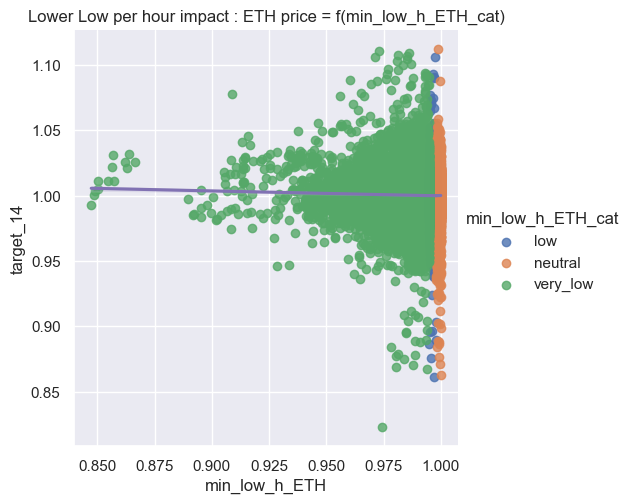

In [145]:
sns.lmplot(x="min_low_h_ETH", y="target_14", hue="min_low_h_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Lower Low per hour impact : ETH price = f(min_low_h_ETH_cat)")

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_54523/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


min_low_h_ETH_cat
low         91014
very_low    83184
neutral     79479
Name: count, dtype: int64

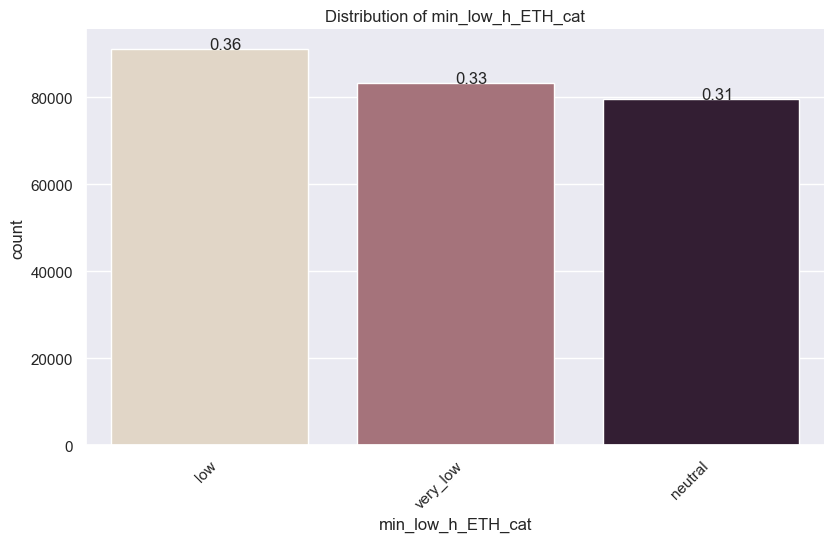

In [146]:

plot_hist_cat(x="min_low_h_ETH_cat", data=df, title="Distribution of min_low_h_ETH_cat")

expected:  [[12608.93189371 65271.60120153 13133.46690476]
 [11010.89170875 56999.16047967 11468.94781159]
 [11524.17639754 59656.23831881 12003.58528365]]
target_cat            down   neutral       up     Total
min_low_h_ETH_cat                                      
low                11509.0   67574.0  11931.0   91014.0
neutral             7582.0   63940.0   7957.0   79479.0
very_low           16053.0   50413.0  16718.0   83184.0
total              35144.0  181927.0  36606.0  253677.0
xi_n =  8339.15806994498
chi2:  8339.15806994498
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


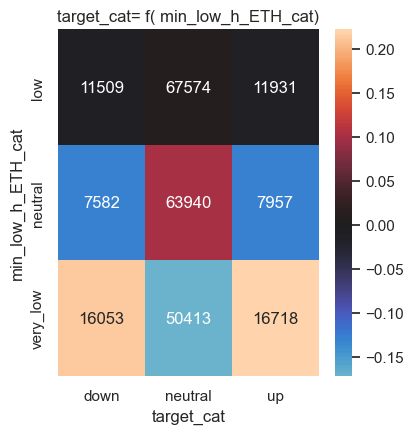

target_cat          down  neutral     up
min_low_h_ETH_cat                       
low                11509    67574  11931
neutral             7582    63940   7957
very_low           16053    50413  16718

In [147]:
plot_cont(X="min_low_h_ETH_cat", Y="target_cat", data=df)

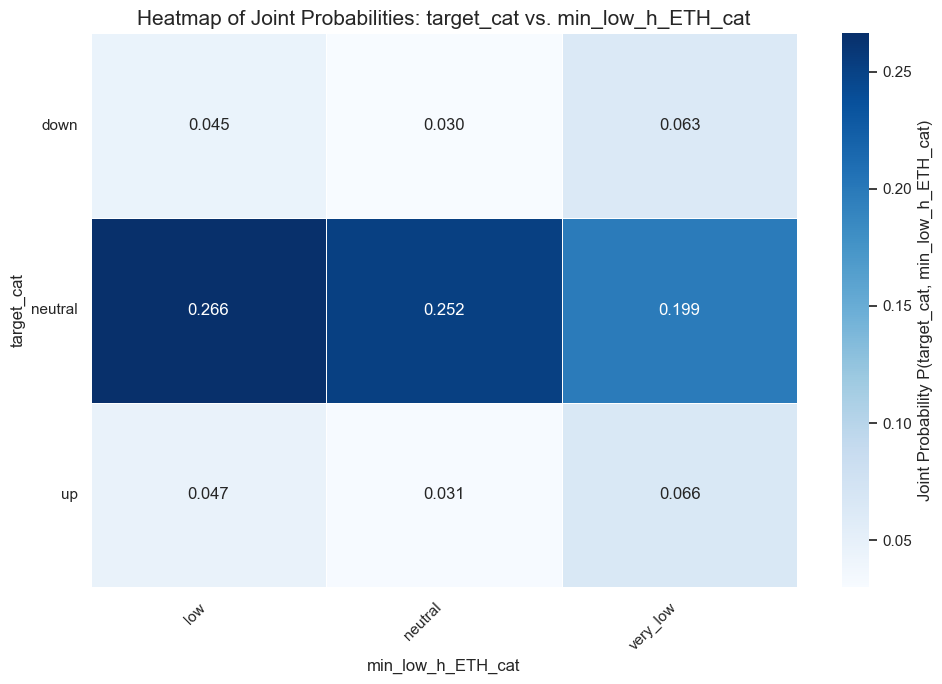

Joint Probability Table:
min_low_h_ETH_cat       low   neutral  very_low
target_cat                                     
down               0.045369  0.029888  0.063281
neutral            0.266378  0.252053  0.198729
up                 0.047032  0.031367  0.065903


In [148]:
probability_table = pd.crosstab(df['target_cat'], df['min_low_h_ETH_cat'], normalize=True)
# 2. Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    probability_table,
    annot=True,        # Show the probability values on the heatmap cells
    fmt=".3f",         # Format annotations to 3 decimal places
    cmap="Blues",      # Colormap (e.g., "Blues", "YlGnBu", "viridis")
    linewidths=.5,     # Add lines between cells for better separation
    cbar_kws={'label': 'Joint Probability P(target_cat, min_low_h_ETH_cat)'} # Label for the color bar
)

plt.title('Heatmap of Joint Probabilities: target_cat vs. min_low_h_ETH_cat', fontsize=15)
plt.ylabel('target_cat', fontsize=12)
plt.xlabel('min_low_h_ETH_cat', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability if long
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Display the probability table (optional)
print("Joint Probability Table:")
print(probability_table)

In [149]:
probability_table.sum().sum()

np.float64(1.0)

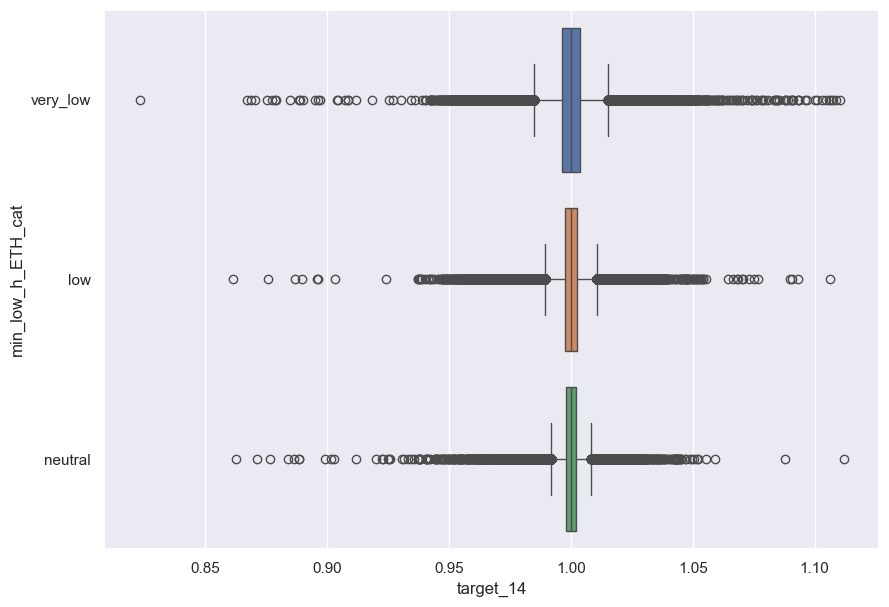

In [150]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="min_low_h_ETH_cat", 
    hue="min_low_h_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
#ax.set_xlim([0.98,1.02])

In [151]:
df["target_14"].describe()

count    253677.000000
mean          1.000070
std           0.007196
min           0.823072
25%           0.997361
50%           1.000089
75%           1.002851
max           1.112129
Name: target_14, dtype: float64

In [152]:
df["target_1"].describe()

count    253677.000000
mean          1.000009
std           0.002652
min           0.907143
25%           0.998967
50%           1.000013
75%           1.001066
max           1.081058
Name: target_1, dtype: float64

<Axes: xlabel='target_14'>

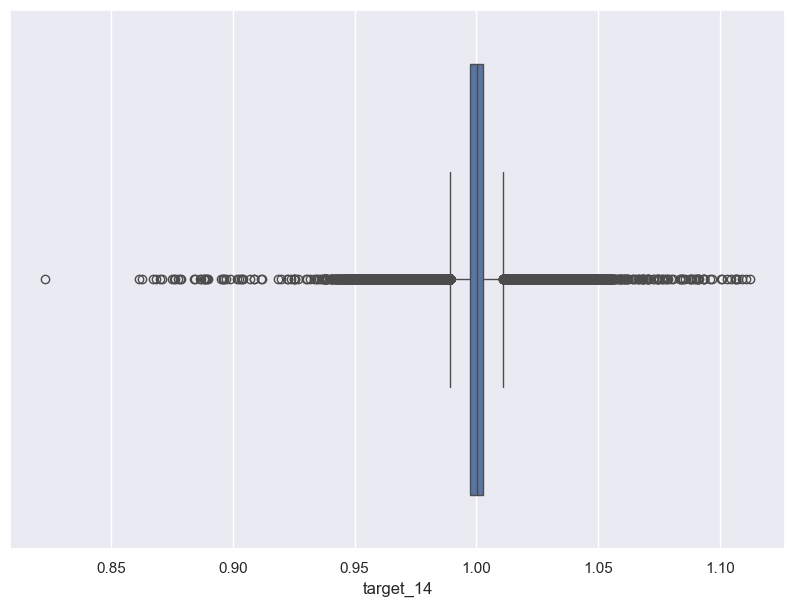

In [153]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

(0.98, 1.02)

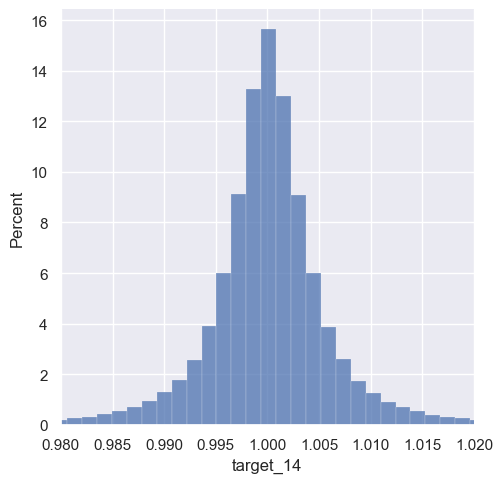

In [154]:
sns.displot(df, x="target_14", kind="hist", stat="percent", bins=200)
ax = plt.gca()
ax.set_xlim([0.98,1.02])

### Chi-2
Distrib are independent between inputs and target (target_14) ?  
Chi-2 must be low  
if not then we can use them as features  
To classify Targets we can say that : if we have : 
- a capital 10000$  
- leverage x10 maxi
- and we want to have 100$ of profit per days
- so:  0.1% up or down can be enough for target

Or find a threshold that can occurs on FUTURE_TARGET points  at a minimum prob to have > 80% chance to touch min or max target  
For example : 
- 40% touch max Target
- 40% touch min Target
- 20% neutral
- Total : 80%


In [228]:
df = pd.DataFrame(np.hstack((X_train_dat[:, -1, :nb_plot], y_train)), 
        columns=list_col_corr)

In [229]:
last_target = list_col_targets[-1]

In [230]:
df.filter(list_col_select)

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0             1.0  0.999782  1.000109  0.999774          0.999171   
1             1.0  0.999548  1.000008  0.999540          0.998785   
2             1.0  1.000084  1.000193  0.999841          0.998860   
3             1.0  1.000770  1.000770  0.999900          0.999669   
4             1.0  0.999330  1.000025  0.999330          0.999178   
...           ...       ...       ...       ...               ...   
253672        1.0  0.998258  1.001698  0.997009          1.009059   
253673        1.0  0.998554  1.001387  0.998451          1.006895   
253674        1.0  1.004900  1.005056  0.999299          1.011829   
253675        1.0  1.001168  1.001491  0.997621          1.011492   
253676        1.0  1.012121  1.014171  0.998487          1.023400   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0               0.999736        0.998393         0.999464   
1               0.999276        0.998113         0.999184   
2               0.999351        0.998243         0.999477   
3               1.000113        0.999003         1.000239   
4               0.999443        0.998335         0.999569   
...                  ...             ...              ...   
253672          1.012239        1.000323         1.000559   
253673          1.010775        0.998877         0.999113   
253674          1.015728        1.003772         1.004009   
253675          1.015731        1.004944         1.003987   
253676          1.028043        1.011526         1.009147   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
0                   2.024261              2.017807  ...  2.588190e-01   
1                   2.023329              2.016878  ...  6.123234e-17   
2                   2.023482              2.017030  ...  6.123234e-17   
3                   2.025023              2.018567  ...  6.123234e-17   
4                   2.023668              2.017215  ...  6.123234e-17   
...                      ...                   ...  ...           ...   
253672              1.043299              1.026564  ...  9.659258e-01   
253673              1.041791              1.025079  ...  9.659258e-01   
253674              1.046896              1.030103  ...  9.659258e-01   
253675              1.048118              1.031306  ...  9.659258e-01   
253676              1.060823              1.043807  ...  9.659258e-01   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
0       0.965926     0.623490    -0.781832           0.97953   
1       1.000000     0.623490    -0.781832           0.97953   
2       1.000000     0.623490    -0.781832           0.97953   
3       1.000000     0.623490    -0.781832           0.97953   
4       1.000000     0.623490    -0.781832           0.97953   
...          ...          ...          ...               ...   
253672  0.258819    -0.222521    -0.974928           1.00000   
253673  0.258819    -0.222521    -0.974928           1.00000   
253674  0.258819    -0.222521    -0.974928           1.00000   
253675  0.258819    -0.222521    -0.974928           1.00000   
253676  0.258819    -0.222521    -0.974928           1.00000   

        day_in_month_sin  day_off  event_pred  event_real  Close_ETH_raw  
0           2.012985e-01      0.0         0.0         0.0    1194.540039  
1           2.012985e-01      0.0         0.0         0.0    1195.089966  
2           2.012985e-01      0.0         0.0         0.0    1195.000000  
3           2.012985e-01      0.0         0.0         0.0    1194.089966  
4           2.012985e-01      0.0         0.0         0.0    1194.890015  
...                  ...      ...         ...         ...            ...  
253672     -2.449294e-16      0.0         0.0         0.0    2520.719971  
253673     -2.449294e-16      0.0         0.0         0.0    2524.370117  
253674     -2.449294e-16      0.0         0.0         0.0    2512.060059  
253675     -2.449294e-16      0.0         0.0     

In [231]:
# find for all features the quantiles 0.10 and 0.90
# transpose the dataframe to have the features as columns
df_cont = df.filter(list_col_select + [last_target]).quantile([0.10, 0.90], axis=0)
df_cont = df_cont.T
# rename the columns
df_cont.columns = ["q10", "q90"]
# store nunique() in a new column
df_cont["nunique"] = df.filter(list_col_select + [last_target]).nunique()

df_cont

q10          q90  nunique
Close_ETH            1.000000     1.000000        1
Open_ETH             0.998280     1.001714    76413
High_ETH             1.000016     1.002502    37382
Low_ETH              0.997419     0.999966    60295
ichi_cloud_a_ETH     0.990221     1.009114   171844
...                       ...          ...      ...
day_off              0.000000     0.000000        2
event_pred           0.000000     0.000000        3
event_real           0.000000     0.000000        3
Close_ETH_raw     1625.745996  3489.247998   135314
target_14            0.993554     1.006591   253286

[104 rows x 3 columns]

#### Target levels
Here we can see the 10% lowest is under -0.64%, the 10% highest are over 0.65% : 

In [232]:
(1.006591 -1)/1 *100

0.6591000000000014

In [233]:
(0.993554 - 1) / 1 * 100

-0.6445999999999952

We can use a level of >= 0.1% => "high" , <=-0.1% "low", otherwise "neutral"

In [234]:
target_level = 0.1/100

In [235]:
y_train.shape

(253677, 15)

In [236]:
y_train.max(axis=1) >= 1+target_level

array([False, False, False, ...,  True,  True,  True], shape=(253677,))

In [237]:
y_train.min(axis=1) <= 1-target_level

array([False,  True,  True, ...,  True,  True, False], shape=(253677,))

Not used anymore :  the last target value : 

In [238]:
Y = "target_last_cat"
df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
df_targets.loc[y_train[:,-1] >= 1+target_level, Y] = "high"
df_targets.loc[y_train[:,-1] <= 1-target_level, Y] = "low"
df_targets[Y].value_counts()

target_last_cat
high       102187
low         97441
neutral     54049
Name: count, dtype: int64

In [239]:
df_targets["target_last_cat"].value_counts()/df_targets.shape[0]

target_last_cat
high       0.402823
low        0.384114
neutral    0.213062
Name: count, dtype: float64

In [240]:
df_targets["target_14"].describe()

count    253677.000000
mean          1.000070
std           0.007196
min           0.823072
25%           0.997361
50%           1.000089
75%           1.002851
max           1.112129
Name: target_14, dtype: float64

In [241]:
df_targets["max_target"] = y_train.max(axis=1)
df_targets["min_target"] = y_train.min(axis=1)
df_targets

target_0  target_1  target_2  target_3  target_4  target_5  target_6  \
0       1.000460  1.000385  0.999623  1.000293  0.999816  1.000050  0.999498   
1       0.999925  0.999163  0.999833  0.999356  0.999590  0.999038  0.999046   
2       0.999238  0.999908  0.999431  0.999665  0.999113  0.999121  0.999473   
3       1.000670  1.000193  1.000427  0.999874  0.999883  1.000234  1.000301   
4       0.999523  0.999757  0.999205  0.999213  0.999565  0.999632  0.999565   
...          ...       ...       ...       ...       ...       ...       ...   
253672  1.001448  0.996564  0.995402  0.983481  0.990876  0.990951  0.988297   
253673  0.995124  0.993963  0.982059  0.989443  0.989518  0.986868  0.986836   
253674  0.998834  0.986871  0.994292  0.994367  0.991704  0.991672  0.992440   
253675  0.988024  0.995453  0.995528  0.992862  0.992830  0.993599  0.991049   
253676  1.007519  1.007596  1.004897  1.004865  1.005643  1.003062  1.010629   

        target_7  target_8  target_9  target_10  target_11  target_12  \
0       0.999506  0.999858  0.999925   0.999858   1.000226   0.999891   
1       0.999398  0.999464  0.999398   0.999766   0.999431   0.999690   
2       0.999540  0.999473  0.999841   0.999506   0.999766   0.999473   
3       1.000234  1.000603  1.000268   1.000528   1.000234   0.999640   
4       0.999933  0.999598  0.999858   0.999565   0.998971   0.998686   
...          ...       ...       ...        ...        ...        ...   
253672  0.988265  0.989031  0.986492   0.993934   0.995977   0.997667   
253673  0.987601  0.985066  0.992497   0.994537   0.996225   0.993384   
253674  0.989893  0.997361  0.999411   1.001107   0.998252   0.997170   
253675  0.998525  1.000578  1.002276   0.999418   0.998334   0.994448   
253676  1.012706  1.014425  1.011533   1.010435   1.006502   1.009294   

        target_13  target_14 target_last_cat  max_target  min_target  
0        1.000151   0.999858         neutral    1.000460    0.999498  
1        0.999398   0.998803             low    0.999925    0.998803  
2        0.998879   0.998594             low    0.999908    0.998594  
3        0.999355   1.000427         neutral    1.000670    0.999355  
4        0.999757   0.999732         neutral    0.999933    0.998686  
...           ...        ...             ...         ...         ...  
253672   0.994823   0.993744             low    1.001448    0.983481  
253673   0.992307   0.988445             low    0.996225    0.982059  
253674   0.993288   0.996043             low    1.001107    0.986871  
253675   0.997206   0.995803             low    1.002276    0.988024  
253676   1.007874   1.007934            high    1.014425    1.003062  

[253677 rows x 18 columns]

Very important : we can see that the last target is not the best to use as a target,   
because it is not well distributed,   
so we will use the max and min, of all the targets, to create a new target   
But we take the first to appear above min/max threshold : +/-0.1%  
Example : 
- if the max is above 1.001 before min is below 0.999, then we will use the max as the target
- if the min is below 0.999 before max is above 1.001, then we will use the min as the target
- if none of them are above/below 1.001/0.999, then we will use the neutral target
  
First Strategy :  TP = SL

In [242]:
Y = "target_cat"
#df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
# low cat : 
b_low = ((y_train.min(axis=1) <= 1-target_level) & (
    (y_train.argmin(axis=1) < y_train.argmax(axis=1)) |
    ((y_train.argmin(axis=1) > y_train.argmax(axis=1)) & (y_train.max(axis=1) < 1+target_level))
    )
)
df_targets.loc[b_low, Y] = "low"
# high cat
b_high = ((y_train.max(axis=1) >= 1+target_level)& (
    (y_train.argmax(axis=1) < y_train.argmin(axis=1)) |
    ((y_train.argmax(axis=1) > y_train.argmin(axis=1)) & (y_train.min(axis=1) > 1-target_level))
    )
)
df_targets.loc[b_high, Y] = "high"

df_targets[Y].value_counts()

target_cat
high       125295
low        123574
neutral      4808
Name: count, dtype: int64

In [243]:
df_targets[Y].value_counts()/df_targets.shape[0]

target_cat
high       0.493915
low        0.487131
neutral    0.018953
Name: count, dtype: float64

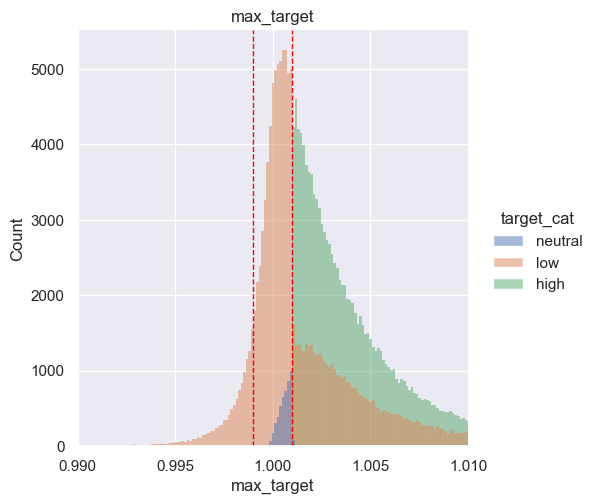

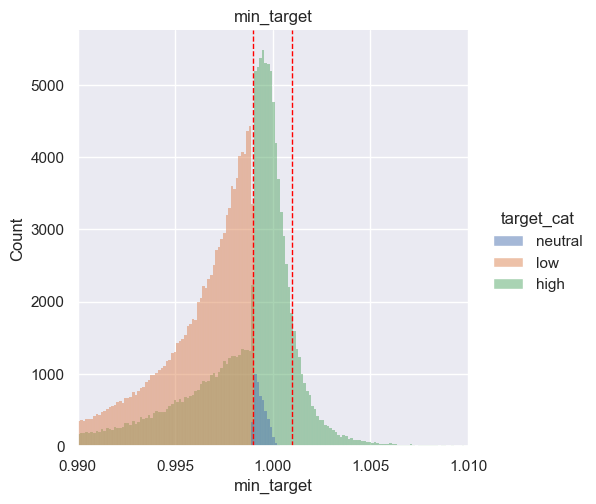

In [244]:
sns.displot(df_targets, x="max_target", hue="target_cat", kind="hist")
ax = plt.gca()
ax.set_xlim([0.99,1.01])
ax.set_title("max_target")
# add vertical lines at 1+target_level and 1-target_level
ax.axvline(1+target_level, color='red', linestyle='dashed', linewidth=1)
ax.axvline(1-target_level, color='red', linestyle='dashed', linewidth=1)

sns.displot(df_targets, x="min_target", hue="target_cat", kind="hist")
ax = plt.gca()
ax.set_xlim([0.99,1.01])
ax.set_title("min_target")
# add vertical lines at 1+target_level and 1-target_level
ax.axvline(1+target_level, color='red', linestyle='dashed', linewidth=1)
ax.axvline(1-target_level, color='red', linestyle='dashed', linewidth=1)

Here : complex graph : 
- If Neutral cat., min or max stay into thresholds.  
- if High cat., min value is around 1
- If Low cat., max value is 1.0005 (1-0.05%) (half the threshold 0.1%)


2eme Strat : TP/SL = 2 : 

In [283]:
1-target_level

0.999

In [284]:
y_train[1,:]

array([0.99992469, 0.99916324, 0.99983265, 0.9993557 , 0.99958999,
       0.99903773, 0.9990461 , 0.99939753, 0.99946448, 0.99939753,
       0.99976571, 0.99943101, 0.9996904 , 0.99939753, 0.99880344])

In [286]:
np.argmax((y_train <= 1-target_level), axis=1)

array([ 0, 14, 13, ...,  0,  0,  0], shape=(253677,))

In [287]:
y_train[-2,:]

array([0.98802374, 0.99545261, 0.99552833, 0.99286207, 0.99283018,
       0.99359938, 0.99104869, 0.99852539, 1.00057789, 1.00227569,
       0.99941813, 0.99833408, 0.99444827, 0.9972062 , 0.99580333])

In [288]:
1-target_level

0.999

In [294]:
1+target_level/2

1.0005

In [285]:
np.argmin((y_train <= 1-target_level), axis=1)

array([0, 0, 0, ..., 9, 8, 0], shape=(253677,))

In [296]:
(y_train.min(axis=1) <= 1-target_level) & (np.argmax((y_train <= 1-target_level), axis=1) <= np.argmax((y_train >= 1+target_level/2), axis=1))

array([False, False, False, ...,  True,  True, False], shape=(253677,))

In [298]:
y_train[-1,:]

array([1.00751892, 1.00759556, 1.00489698, 1.00486471, 1.00564322,
       1.00306162, 1.01062894, 1.01270633, 1.01442471, 1.0115325 ,
       1.01043532, 1.00650241, 1.00929377, 1.00787389, 1.0079344 ])

In [299]:
1+target_level

1.001

In [297]:
(y_train.max(axis=1) >= 1+target_level) & (np.argmax((y_train >= 1+target_level), axis=1) <= np.argmax((y_train <= 1-target_level/2), axis=1))

array([False, False, False, ..., False, False,  True], shape=(253677,))

In [300]:
Y = "target_cat"
#df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
# low cat : if 
b_low =(y_train.min(axis=1) <= 1-target_level) & (np.argmax((y_train <= 1-target_level), axis=1) <= np.argmax((y_train >= 1+target_level/2), axis=1))
df_targets.loc[b_low, Y] = "low"
# high cat
b_high = (y_train.max(axis=1) >= 1+target_level) & (np.argmax((y_train >= 1+target_level), axis=1) <= np.argmax((y_train <= 1-target_level/2), axis=1))

df_targets.loc[b_high, Y] = "high"

df_targets[Y].value_counts()

target_cat
neutral    106896
high        73903
low         72878
Name: count, dtype: int64

In [245]:
Y

'target_cat'

In [246]:
# Calculate classes, contigency chi2 and p value : for each feature and each past value
# - for all lags of target,  we have one categorical variable :
# - high mean we have touch high target level, 
# - low mean we have touch low target level,
# - neutral mean we have not touch target level
list_df = []
for I_past in [0, PAST_HISTORY-1]: #range(PAST_HISTORY):
    # Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
    df_ = pd.DataFrame(X_train_dat[:, I_past, :nb_plot], columns=list_col_select[:nb_plot])
    df_ = pd.concat([df_, df_targets], axis=1)
    #df_ = pd.DataFrame(np.hstack((X_train_dat[:, I_past, :nb_plot], y_train)), 
    #    columns=list_col_corr)
    # df_[Y] = "neutral"
    # df_.loc[(y_train.argmax(axis=1) < y_train.argmin(axis=1)) & (y_train.max(axis=1) >= 1+target_level), Y] = "high"
    # df_.loc[(y_train.argmin(axis=1) < y_train.argmax(axis=1)) & (y_train.min(axis=1) <= 1-target_level), Y] = "low"
    for col_name in list_col_select:
        X = col_name + "_cat"
        df_[X] = "neutral"
        if df_cont.at[col_name, "nunique"] > 3:
            df_.loc[df_[col_name] >= df_cont.at[col_name, "q90"], X] = "high"
            df_.loc[df_[col_name] <= df_cont.at[col_name, "q10"], X] = "low"
        elif df_cont.at[col_name, "nunique"] == 3:
            unique_values = df_[col_name].unique()
            # sort the unique values
            unique_values.sort()
            # assign the categories
            df_.loc[df_[col_name] == unique_values[2], X] = "high"
            df_.loc[df_[col_name] == unique_values[1], X] = "neutral"
            df_.loc[df_[col_name] == unique_values[0], X] = "low"
        elif df_cont.at[col_name, "nunique"] == 2:
            unique_values = df_[col_name].unique()
            # sort the unique values
            unique_values.sort()
            # assign the categories
            df_.loc[df_[col_name] == unique_values[1], X] = "high"
            df_.loc[df_[col_name] == unique_values[0], X] = "low"
    """ # create categories
    for col_name in list_col_select + [last_target]:
        X = col_name + "_cat"
        df[X] = df[col_name].apply(lambda x: apply_cat(x, col_name)) """
    list_df.append(df_)

    df_cont[f"chi2_{I_past}"] = np.nan
    df_cont[f"p-value_{I_past}"] = np.nan
    # calculate contingency table for each feature
    arr_chi2 = np.full(len(list_col_select), np.nan)
    arr_p = np.full(len(list_col_select), np.nan)
    for I, col_name in enumerate(list_col_select):
        X = col_name + "_cat"
        c, chi2, p, dof, expected = contingency_table(X, "target_cat", df_)
        print(f"Past: {I_past}, Feature: {col_name}, Chi2: {chi2}, p-value: {p}")
        # store chi2 and p-value in a dataframe df_cont
        #df_cont.at[col_name, f"chi2_{I_past}"] = chi2
        #df_cont.at[col_name, f"p-value_{I_past}"] = p
        arr_chi2[I] = chi2
        arr_p[I] = p
    df_cont.loc[list_col_select, f"chi2_{I_past}"] = arr_chi2
    df_cont.loc[list_col_select, f"p-value_{I_past}"] = arr_p

df_cont

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_54523/4130127896.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[X] = "neutral"
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_54523/4130127896.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[X] = "neutral"
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_54523/4130127896.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

Past: 0, Feature: Close_ETH, Chi2: 0.0, p-value: 1.0
Past: 0, Feature: Open_ETH, Chi2: 4085.969392452794, p-value: 0.0
Past: 0, Feature: High_ETH, Chi2: 2663.8111838608083, p-value: 0.0
Past: 0, Feature: Low_ETH, Chi2: 2594.0607297497504, p-value: 0.0
Past: 0, Feature: ichi_cloud_a_ETH, Chi2: 3071.909093414156, p-value: 0.0
Past: 0, Feature: ichi_cloud_b_ETH, Chi2: 2627.269692886185, p-value: 0.0
Past: 0, Feature: ichi_kijun_ETH, Chi2: 4973.966951516217, p-value: 0.0
Past: 0, Feature: ichi_tenkan_ETH, Chi2: 4497.590869752226, p-value: 0.0
Past: 0, Feature: ichi_cloud_a_day_ETH, Chi2: 1037.4579430711537, p-value: 2.720489069774203e-223
Past: 0, Feature: ichi_cloud_b_day_ETH, Chi2: 1026.770508756446, p-value: 5.635149514366565e-221
Past: 0, Feature: ichi_kijun_day_ETH, Chi2: 1486.6801151335976, p-value: 0.0
Past: 0, Feature: ichi_tenkan_day_ETH, Chi2: 2231.169087168754, p-value: 0.0
Past: 0, Feature: ichi_cloud_a_week_ETH, Chi2: 632.1738734525603, p-value: 1.684092448617156e-135
Past: 0,

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_54523/4130127896.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[X] = "neutral"
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_54523/4130127896.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[X] = "neutral"
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_54523/4130127896.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

Past: 71, Feature: Close_ETH, Chi2: 0.0, p-value: 1.0
Past: 71, Feature: Open_ETH, Chi2: 1192.3151099247218, p-value: 7.381633287846889e-257
Past: 71, Feature: High_ETH, Chi2: 2254.828358661392, p-value: 0.0
Past: 71, Feature: Low_ETH, Chi2: 2870.458795075077, p-value: 0.0
Past: 71, Feature: ichi_cloud_a_ETH, Chi2: 1248.7636277750619, p-value: 4.271386549140396e-269
Past: 71, Feature: ichi_cloud_b_ETH, Chi2: 1245.9282925285383, p-value: 1.7590107320233693e-268
Past: 71, Feature: ichi_kijun_ETH, Chi2: 1346.328013099238, p-value: 3.001595057256782e-290
Past: 71, Feature: ichi_tenkan_ETH, Chi2: 1378.2961275231307, p-value: 3.513508171528693e-297
Past: 71, Feature: ichi_cloud_a_day_ETH, Chi2: 964.7486897464199, p-value: 1.5551325313542791e-207
Past: 71, Feature: ichi_cloud_b_day_ETH, Chi2: 984.3022338647878, p-value: 9.004625904114786e-212
Past: 71, Feature: ichi_kijun_day_ETH, Chi2: 1133.4365125555785, p-value: 4.280764780812128e-244
Past: 71, Feature: ichi_tenkan_day_ETH, Chi2: 1160.6243

q10          q90  nunique       chi2_0  \
Close_ETH            1.000000     1.000000        1     0.000000   
Open_ETH             0.998280     1.001714    76413  4085.969392   
High_ETH             1.000016     1.002502    37382  2663.811184   
Low_ETH              0.997419     0.999966    60295  2594.060730   
ichi_cloud_a_ETH     0.990221     1.009114   171844  3071.909093   
...                       ...          ...      ...          ...   
day_off              0.000000     0.000000        2     3.935632   
event_pred           0.000000     0.000000        3     1.358535   
event_real           0.000000     0.000000        3     1.059340   
Close_ETH_raw     1625.745996  3489.247998   135314   572.449178   
target_14            0.993554     1.006591   253286          NaN   

                      p-value_0      chi2_71     p-value_71  
Close_ETH          1.000000e+00     0.000000   1.000000e+00  
Open_ETH           0.000000e+00  1192.315110  7.381633e-257  
High_ETH           0.000000e+00  2254.828359   0.000000e+00  
Low_ETH            0.000000e+00  2870.458795   0.000000e+00  
ichi_cloud_a_ETH   0.000000e+00  1248.763628  4.271387e-269  
...                         ...          ...            ...  
day_off            1.397617e-01     0.388339   8.235184e-01  
event_pred         8.513689e-01     4.520775   3.400912e-01  
event_real         9.006686e-01     1.001082   9.096319e-01  
Close_ETH_raw     1.420568e-122   576.078983  2.328066e-123  
target_14                   NaN          NaN            NaN  

[104 rows x 7 columns]

In [247]:
df = list_df[-1]

In [248]:
pd.crosstab(df['Volume_ETH_cat'], df['target_cat'], margins=True, normalize=True)

target_cat          high       low   neutral       All
Volume_ETH_cat                                        
high            0.050564  0.049401  0.000035  0.100001
low             0.045999  0.044529  0.009473  0.100001
neutral         0.397352  0.393201  0.009445  0.799998
All             0.493915  0.487131  0.018953  1.000000

#### First LAG (oldest)

In [249]:
df = list_df[0]

Text(0.5, 1.0, 'Min Chi2 between FIRST Lag and Target cat')

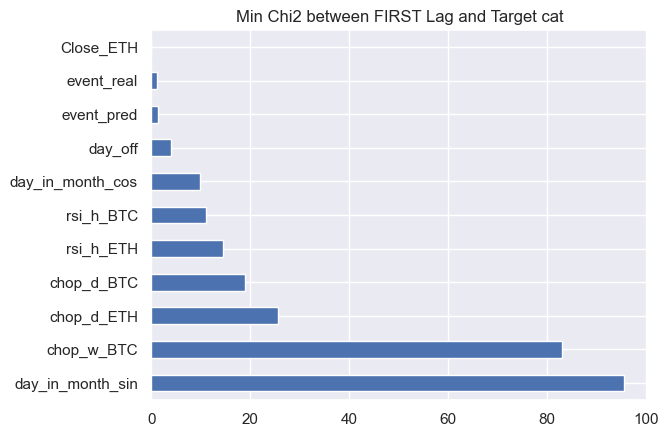

In [250]:
# find chi2_0 values in the 10% highest quantiles 
min_quantile_chi2_10 = df_cont["chi2_0"].quantile(0.10)
min_chi2_0 = df_cont["chi2_0"].sort_values(ascending=False)
min_chi2_0[min_chi2_0.values<min_quantile_chi2_10].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Min Chi2 between FIRST Lag and Target cat")


Results : We can see that some features have less impact on distrib :
- we are not going to study them
- we are going to study the features with the highest chi2

Text(0.5, 1.0, 'Max Chi2 between FIRST Lag and Target cat')

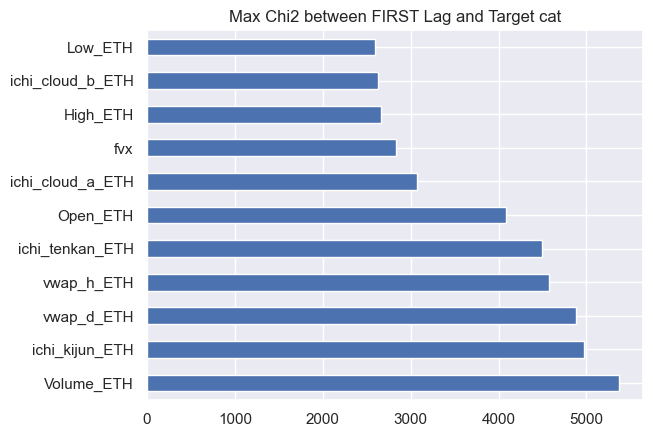

In [251]:
# find chi2_0 values in the 10% highest quantiles 
max_quantile_chi2_90 = df_cont["chi2_0"].quantile(0.90)
max_chi2_0 = df_cont["chi2_0"].sort_values(ascending=False)
max_chi2_0[max_chi2_0.values>max_quantile_chi2_90].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Max Chi2 between FIRST Lag and Target cat")

expected:  [[ 12517.79420286  12345.85498882    480.35080831]
 [ 12546.93521683  12374.59573395    481.46904922]
 [100230.2705803   98853.54927723   3846.18014246]]
target_cat          high       low  neutral     Total
Volume_ETH_cat                                       
high             12679.0   12569.0     96.0   25344.0
low              11856.0   11570.0   1977.0   25403.0
neutral         100760.0   99435.0   2735.0  202930.0
total           125295.0  123574.0   4808.0  253677.0
xi_n =  5376.647111518828
chi2:  5376.647111518828
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


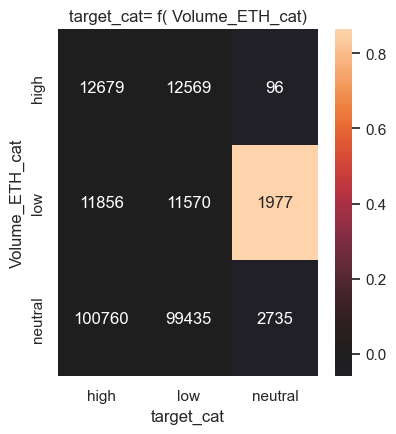

target_cat        high    low  neutral
Volume_ETH_cat                        
high             12679  12569       96
low              11856  11570     1977
neutral         100760  99435     2735

In [252]:
feat_name_max = max_chi2_0.index[0]
# plot contingency table for the feature with the highest chi2
X = feat_name_max + "_cat"
Y = "target_cat"
I_past = 0
plot_cont(X=X, Y=Y, data=df)

In [253]:
Y

'target_cat'

In [254]:
# create contingency dataframe
col_name_1 = f"{max_chi2_0.index[1]}_cat"
col_name_2 = f"{max_chi2_0.index[2]}_cat"
df_cross = pd.crosstab([df[X], df[col_name_1], df[col_name_2]], df[Y], margins=False, dropna=False)
# get target names
target_cat_names = df_cross.columns.to_list()
print("target_cat_names: ", target_cat_names)
# get index lengths
nb_level_0 = len(df_cross.index.levels[0])
nb_level_1 = len(df_cross.index.levels[1])
nb_level_2 = len(df_cross.index.levels[2])  
nb_targets = df_cross.shape[1]
# create array contingency
arr_cont = np.empty((nb_level_0,nb_level_1,nb_level_2,nb_targets))
for I_0, level_0 in enumerate(df_cross.index.levels[0]):
    #print("#level_0: ", I_0)
    for I_1,level_1 in enumerate(df_cross.index.levels[1]):
        #print("#level_1: ", I_1)
        arr_cont[I_0, I_1] = df_cross.loc[(level_0, level_1)].values
print("arr_cont.shape : ", arr_cont.shape)
# add probs
df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# calc chi2, p-value, expected frequencies
res = stats.chi2_contingency(arr_cont)
print("chi2: ", res.statistic)
print("p-value: ", res.pvalue)
# add expected frequencies to df_cross
arr_exp = res.expected_freq.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"exp_{col}"] = arr_exp[:,I]
# get sign of difference between observed and expected frequencies
arr_sign = np.sign(arr_cont - res.expected_freq)
# calc chi2 ratio and add to df_cross
arr_chi2_ratio = arr_sign*((arr_cont - res.expected_freq)**2/res.expected_freq)/res.statistic
arr_chi2_ration_reshape = arr_chi2_ratio.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"chi2_pc_{col}"] = 100*arr_chi2_ration_reshape[:,I]
df_cross

target_cat_names:  ['high', 'low', 'neutral']
arr_cont.shape :  (3, 3, 3, 3)
chi2:  492372.3728860185
p-value:  0.0


target_cat                                         high    low  neutral  \
Volume_ETH_cat ichi_kijun_ETH_cat vwap_d_ETH_cat                          
high           high               high             4457   4367       12   
                                  low                 5      2        0   
                                  neutral           158    125        1   
               low                high                2      3        0   
                                  low              5060   5018       17   
                                  neutral           164    174        1   
               neutral            high              265    255        3   
                                  low               313    305        3   
                                  neutral          2255   2320       59   
low            high               high             2869   2321       83   
                                  low                 0      0        0   
                                  neutral            41     48        2   
               low                high                0      0        0   
                                  low              2250   2531       74   
                                  neutral            31     31        1   
               neutral            high              205    162       16   
                                  low               263    263       38   
                                  neutral          6197   6214     1763   
neutral        high               high            32124  29646      234   
                                  low                 1      2        0   
                                  neutral           831    793       17   
               low                high                1      3        0   
                                  low             30763  31894      227   
                                  neutral           854    765       12   
               neutral            high             1906   1832       57   
                                  low              2182   2363       98   
                                  neutral         32098  32137     2090   

target_cat                                          p_high     p_low  \
Volume_ETH_cat ichi_kijun_ETH_cat vwap_d_ETH_cat                       
high           high               high            0.504414  0.494228   
                                  low             0.714286  0.285714   
                                  neutral         0.556338  0.440141   
               low                high            0.400000  0.600000   
                                  low             0.501238  0.497078   
                                  neutral         0.483776  0.513274   
               neutral            high            0.506692  0.487572   
                                  low             0.504026  0.491143   
                                  neutral         0.486621  0.500647   
low            high               high            0.544093  0.440167   
                                  low                  NaN       NaN   
                                  neutral         0.450549  0.527473   
               low                high                 NaN       NaN   
                                  low             0.463440  0.521318   
                                  neutral         0.492063  0.492063   
               neutral            high            0.535248  0.422977   
                                  low             0.466312  0.466312   
                                  neutral         0.437209  0.438408   
neutral        high               high            0.518096  0.478130   
                                  low             0.333333  0.666667   
                                  neutral         0.506399  0.483242   
               low                high            0.250000  0.750000   
                                  low             0.489202  0.507188   
                        

In [255]:
2573 / df.shape[0]

0.010142819412087023

In [256]:
100*5/60

8.333333333333334

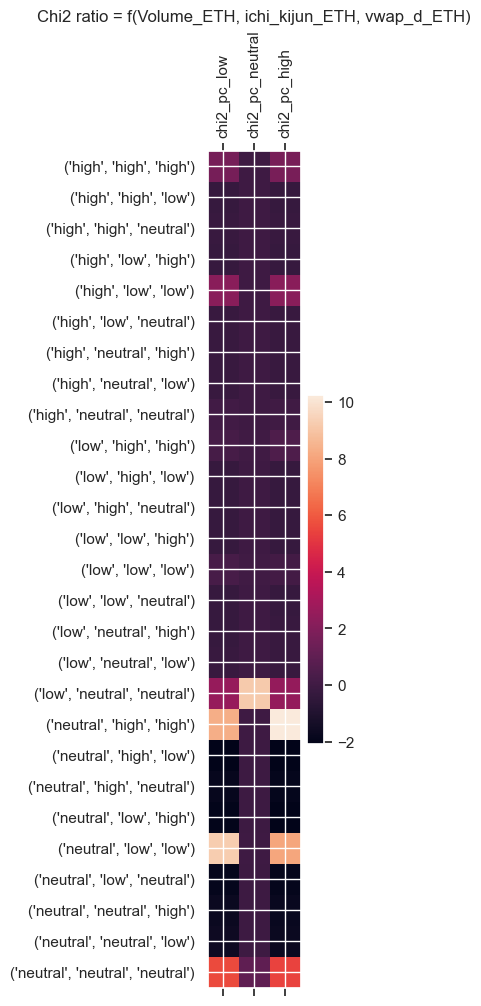

In [257]:
plot_corr(
    df_cross[["chi2_pc_low","chi2_pc_neutral","chi2_pc_high"]], 
    title = f"Chi2 ratio = f({max_chi2_0.index[0]}, {max_chi2_0.index[1]}, {max_chi2_0.index[2]})", 
    size=1.5,
)

#### LAST Lag (newest)

In [258]:
df = list_df[-1]

Text(0.5, 1.0, 'Min Chi2 between LAST Lag and LAST Target')

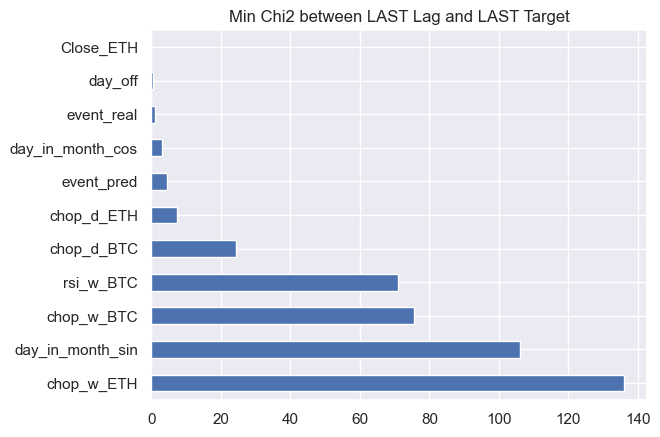

In [259]:
# find chi2_0 values in the 10% highest quantiles 
chi2_name = f"chi2_{PAST_HISTORY-1}"
min_quantile_chi2_q10 = df_cont[chi2_name].quantile(0.10)
min_chi2_last = df_cont[chi2_name].sort_values(ascending=False)
min_chi2_last[min_chi2_last.values<min_quantile_chi2_q10].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Min Chi2 between LAST Lag and LAST Target")

Text(0.5, 1.0, 'Max Chi2 between LAST Lag and Target cat')

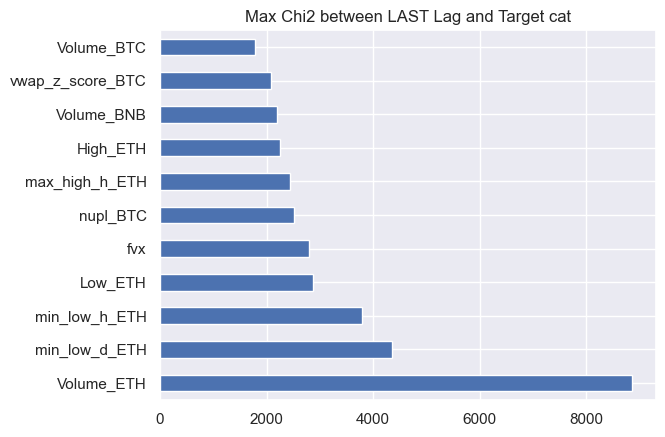

In [260]:
# find chi2_0 values in the 10% highest quantiles 
max_quantile_chi2_q90 = df_cont[chi2_name].quantile(0.90)
max_chi2_last = df_cont[chi2_name].sort_values(ascending=False)
max_chi2_last[max_chi2_last.values>max_quantile_chi2_q90].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Max Chi2 between LAST Lag and Target cat")

expected:  [[ 12529.64817465  12357.54613938    480.80568597]
 [ 12529.64817465  12357.54613938    480.80568597]
 [100235.70365071  98858.90772124   3846.38862806]]
target_cat          high       low  neutral     Total
Volume_ETH_cat                                       
high             12827.0   12532.0      9.0   25368.0
low              11669.0   11296.0   2403.0   25368.0
neutral         100799.0   99746.0   2396.0  202941.0
total           125295.0  123574.0   4808.0  253677.0
xi_n =  8865.501452903805
chi2:  8865.501452903805
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


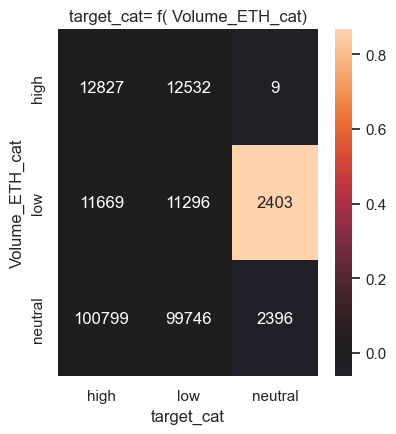

target_cat        high    low  neutral
Volume_ETH_cat                        
high             12827  12532        9
low              11669  11296     2403
neutral         100799  99746     2396

In [261]:
feat_name_max = max_chi2_last.index[0]
# plot contingency table for the feature with the highest chi2
X = feat_name_max + "_cat"
Y = "target_cat"
plot_cont(X=X, Y=Y, data=df)

In [262]:
Y

'target_cat'

In [263]:
X

'Volume_ETH_cat'

In [264]:
max_chi2_last.index[1]

'min_low_d_ETH'

In [265]:
# create contingency dataframe
col_name_1 = f"{max_chi2_last.index[1]}_cat"
col_name_2 = f"{max_chi2_last.index[2]}_cat"
df_cross = pd.crosstab([df[X], df[col_name_1], df[col_name_2]], df[Y], margins=False, dropna=False)
# get target names
target_cat_names = df_cross.columns.to_list()
print("target_cat_names: ", target_cat_names)
# get index lengths
nb_level_0 = len(df_cross.index.levels[0])
nb_level_1 = len(df_cross.index.levels[1])
nb_level_2 = len(df_cross.index.levels[2])  
nb_targets = df_cross.shape[1]
# create array contingency
arr_cont = np.empty((nb_level_0,nb_level_1,nb_level_2,nb_targets))
for I_0, level_0 in enumerate(df_cross.index.levels[0]):
    #print("#level_0: ", I_0)
    for I_1,level_1 in enumerate(df_cross.index.levels[1]):
        #print("#level_1: ", I_1)
        arr_cont[I_0, I_1] = df_cross.loc[(level_0, level_1)].values
print("arr_cont.shape : ", arr_cont.shape)
# add probs
df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# calc chi2, p-value, expected frequencies
res = stats.chi2_contingency(arr_cont)
print("chi2: ", res.statistic)
print("p-value: ", res.pvalue)
# add expected frequencies to df_cross
arr_exp = res.expected_freq.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"exp_{col}"] = arr_exp[:,I]
# get sign of difference between observed and expected frequencies
arr_sign = np.sign(arr_cont - res.expected_freq)
# calc chi2 ratio and add to df_cross
arr_chi2_ratio = arr_sign*((arr_cont - res.expected_freq)**2/res.expected_freq)/res.statistic
arr_chi2_ration_reshape = arr_chi2_ratio.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"chi2_pc_{col}"] = 100*arr_chi2_ration_reshape[:,I]
df_cross

target_cat_names:  ['high', 'low', 'neutral']
arr_cont.shape :  (3, 3, 3, 3)
chi2:  156130.93126436934
p-value:  0.0


target_cat                                           high    low  neutral  \
Volume_ETH_cat min_low_d_ETH_cat min_low_h_ETH_cat                          
high           high              high                 229    164        0   
                                 low                    0      0        0   
                                 neutral             1478   1344        1   
               low               high                  80     62        0   
                                 low                 1898   2021        0   
                                 neutral             1282   1259        0   
               neutral           high                 347    257        1   
                                 low                 3116   3362        1   
                                 neutral             4397   4063        6   
low            high              high                 687    495      519   
                                 low                    0      0        0   
                                 neutral             1515   1347      606   
               low               high                   7      7        0   
                                 low                    0      0        0   
                                 neutral               96    110        0   
               neutral           high                1610   1362      434   
                                 low                   20     17        0   
                                 neutral             7734   7958      844   
neutral        high              high                1636   1189      226   
                                 low                    0      0        0   
                                 neutral             7232   6277      423   
               low               high                 420    409        2   
                                 low                 1393   1572        0   
                                 neutral             7477   7272        1   
               neutral           high                7892   6853      482   
                                 low                 5810   6158        0   
                                 neutral            68939  70016     1262   

target_cat                                            p_high     p_low  \
Volume_ETH_cat min_low_d_ETH_cat min_low_h_ETH_cat                       
high           high              high               0.582697  0.417303   
                                 low                     NaN       NaN   
                                 neutral            0.523557  0.476089   
               low               high               0.563380  0.436620   
                                 low                0.484307  0.515693   
                                 neutral            0.504526  0.495474   
               neutral           high               0.573554  0.424793   
                                 low                0.480938  0.518907   
                                 neutral            0.519372  0.479920   
low            high              high               0.403880  0.291005   
                                 low                     NaN       NaN   
                                 neutral            0.436851  0.388408   
               low               high               0.500000  0.500000   
                                 low                     NaN       NaN   
                                 neutral            0.466019  0.533981   
               neutral           high               0.472695  0.399883   
                                 low                0.540541  0.459459   
                                 neutral            0.467707  0.481253   
neutral        high              high               0.536218  0.389708   
                                 low                     NaN       NaN   
                                 neutral            0.519093  0.450546   
               low               high               0.505415  0.

In [266]:
df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross

target_cat                                           high    low  neutral  \
Volume_ETH_cat min_low_d_ETH_cat min_low_h_ETH_cat                          
high           high              high                 229    164        0   
                                 low                    0      0        0   
                                 neutral             1478   1344        1   
               low               high                  80     62        0   
                                 low                 1898   2021        0   
                                 neutral             1282   1259        0   
               neutral           high                 347    257        1   
                                 low                 3116   3362        1   
                                 neutral             4397   4063        6   
low            high              high                 687    495      519   
                                 low                    0      0        0   
                                 neutral             1515   1347      606   
               low               high                   7      7        0   
                                 low                    0      0        0   
                                 neutral               96    110        0   
               neutral           high                1610   1362      434   
                                 low                   20     17        0   
                                 neutral             7734   7958      844   
neutral        high              high                1636   1189      226   
                                 low                    0      0        0   
                                 neutral             7232   6277      423   
               low               high                 420    409        2   
                                 low                 1393   1572        0   
                                 neutral             7477   7272        1   
               neutral           high                7892   6853      482   
                                 low                 5810   6158        0   
                                 neutral            68939  70016     1262   

target_cat                                            p_high     p_low  \
Volume_ETH_cat min_low_d_ETH_cat min_low_h_ETH_cat                       
high           high              high               0.582697  0.417303   
                                 low                     NaN       NaN   
                                 neutral            0.523557  0.476089   
               low               high               0.563380  0.436620   
                                 low                0.484307  0.515693   
                                 neutral            0.504526  0.495474   
               neutral           high               0.573554  0.424793   
                                 low                0.480938  0.518907   
                                 neutral            0.519372  0.479920   
low            high              high               0.403880  0.291005   
                                 low                     NaN       NaN   
                                 neutral            0.436851  0.388408   
               low               high               0.500000  0.500000   
                                 low                     NaN       NaN   
                                 neutral            0.466019  0.533981   
               neutral           high               0.472695  0.399883   
                                 low                0.540541  0.459459   
                                 neutral            0.467707  0.481253   
neutral        high              high               0.536218  0.389708   
                                 low                     NaN       NaN   
                                 neutral            0.519093  0.450546   
               low               high               0.505415  0.

In [267]:
df_cross["high"] / df.shape[0]

Volume_ETH_cat  min_low_d_ETH_cat  min_low_h_ETH_cat
high            high               high                 0.000903
                                   low                  0.000000
                                   neutral              0.005826
                low                high                 0.000315
                                   low                  0.007482
                                   neutral              0.005054
                neutral            high                 0.001368
                                   low                  0.012283
                                   neutral              0.017333
low             high               high                 0.002708
                                   low                  0.000000
                                   neutral              0.005972
                low                high                 0.000028
                                   low                  0.000000
                                   ne

In [268]:
df_cross["high"].sum() / df_cross[["high", "neutral","low"]].sum().sum()

np.float64(0.4939154909589754)

In [269]:
df_cross["low"].sum() / df_cross[["high", "neutral","low"]].sum().sum()

np.float64(0.48713127323328487)

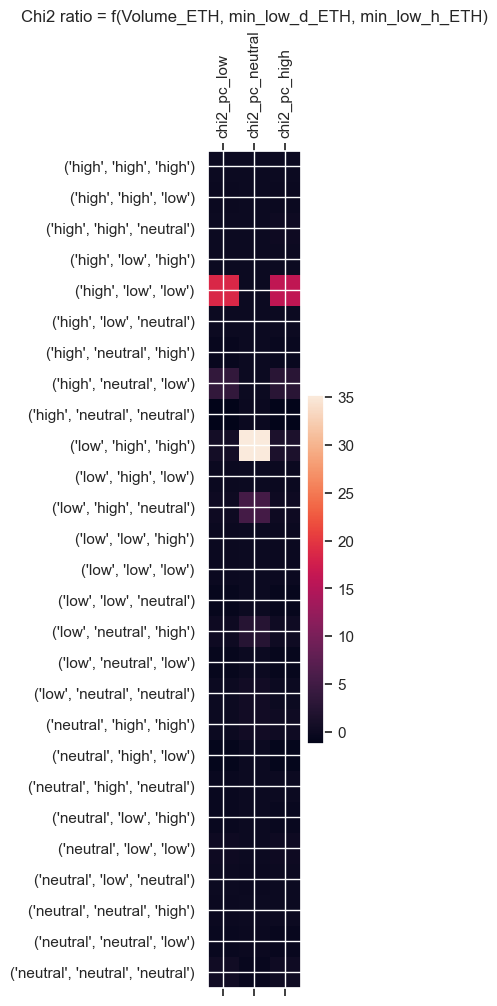

In [270]:
plot_corr(
    df_cross[["chi2_pc_low","chi2_pc_neutral","chi2_pc_high"]], 
    title = f"Chi2 ratio = f({max_chi2_last.index[0]}, {max_chi2_last.index[1]}, {max_chi2_last.index[2]})", 
    size=1.5,
)

In [271]:
list_len_levels = []
for I in range(len(df_cross.index.levels)): 
    list_len_levels.append(len(df_cross.index.levels[I]))
list_len_levels

[3, 3, 3]

In [272]:
df_cross.index.unique(level=2)

Index(['high', 'low', 'neutral'], dtype='object', name='min_low_h_ETH_cat')

##### check on first LAG (oldest)
We keep the same Features to do the cross table, and apply cat using for the FIRST Lag (oldest)  
To detect if these features are still important with oldest time

In [273]:
df = list_df[0]

In [274]:
# create contingency dataframe
col_name_1 = f"{max_chi2_last.index[1]}_cat"
col_name_2 = f"{max_chi2_last.index[2]}_cat"
df_cross = pd.crosstab([df[X], df[col_name_1], df[col_name_2]], df[Y], margins=False, dropna=False)
# get target names
target_cat_names = df_cross.columns.to_list()
print("target_cat_names: ", target_cat_names)
# get index lengths
nb_level_0 = len(df_cross.index.levels[0])
nb_level_1 = len(df_cross.index.levels[1])
nb_level_2 = len(df_cross.index.levels[2])  
nb_targets = df_cross.shape[1]
# create array contingency
arr_cont = np.empty((nb_level_0,nb_level_1,nb_level_2,nb_targets))
for I_0, level_0 in enumerate(df_cross.index.levels[0]):
    #print("#level_0: ", I_0)
    for I_1,level_1 in enumerate(df_cross.index.levels[1]):
        #print("#level_1: ", I_1)
        arr_cont[I_0, I_1] = df_cross.loc[(level_0, level_1)].values
print("arr_cont.shape : ", arr_cont.shape)
# add probs
df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# calc chi2, p-value, expected frequencies
res = stats.chi2_contingency(arr_cont)
print("chi2: ", res.statistic)
print("p-value: ", res.pvalue)
# add expected frequencies to df_cross
arr_exp = res.expected_freq.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"exp_{col}"] = arr_exp[:,I]
# get sign of difference between observed and expected frequencies
arr_sign = np.sign(arr_cont - res.expected_freq)
# calc chi2 ratio and add to df_cross
arr_chi2_ratio = arr_sign*((arr_cont - res.expected_freq)**2/res.expected_freq)/res.statistic
arr_chi2_ration_reshape = arr_chi2_ratio.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"chi2_pc_{col}"] = 100*arr_chi2_ration_reshape[:,I]
df_cross

target_cat_names:  ['high', 'low', 'neutral']
arr_cont.shape :  (3, 3, 3, 3)
chi2:  110126.3106098163
p-value:  0.0


target_cat                                           high    low  neutral  \
Volume_ETH_cat min_low_d_ETH_cat min_low_h_ETH_cat                          
high           high              high                1741   1683        9   
                                 low                    0      0        0   
                                 neutral              330    327        9   
               low               high                 395    428        0   
                                 low                 2974   2810        0   
                                 neutral              440    476        0   
               neutral           high                1402   1350        8   
                                 low                 3419   3601       28   
                                 neutral             1978   1894       42   
low            high              high                2434   2012      466   
                                 low                    0      0        0   
                                 neutral              660    623      323   
               low               high                  28     19        0   
                                 low                   82    116        0   
                                 neutral               40     56        0   
               neutral           high                3047   2618      409   
                                 low                 1287   1383       25   
                                 neutral             4278   4743      754   
neutral        high              high               13941  12713      388   
                                 low                    0      0        0   
                                 neutral             2326   2182      258   
               low               high                2092   2108        3   
                                 low                 6886   6874        3   
                                 neutral             2266   2459        5   
               neutral           high               22304  20631      544   
                                 low                21035  21990      126   
                                 neutral            29910  30478     1408   

target_cat                                            p_high     p_low  \
Volume_ETH_cat min_low_d_ETH_cat min_low_h_ETH_cat                       
high           high              high               0.507137  0.490242   
                                 low                     NaN       NaN   
                                 neutral            0.495495  0.490991   
               low               high               0.479951  0.520049   
                                 low                0.514177  0.485823   
                                 neutral            0.480349  0.519651   
               neutral           high               0.507971  0.489130   
                                 low                0.485102  0.510925   
                                 neutral            0.505365  0.483904   
low            high              high               0.495521  0.409609   
                                 low                     NaN       NaN   
                                 neutral            0.410959  0.387920   
               low               high               0.595745  0.404255   
                                 low                0.414141  0.585859   
                                 neutral            0.416667  0.583333   
               neutral           high               0.501646  0.431017   
                                 low                0.477551  0.513173   
                                 neutral            0.437647  0.485217   
neutral        high              high               0.515531  0.470121   
                                 low                     NaN       NaN   
                                 neutral            0.488040  0.457826   
               low               high               0.497740  0.

Results : same rank for chi-2  as for last lag, but smaller values: time between have impact => less direct impact

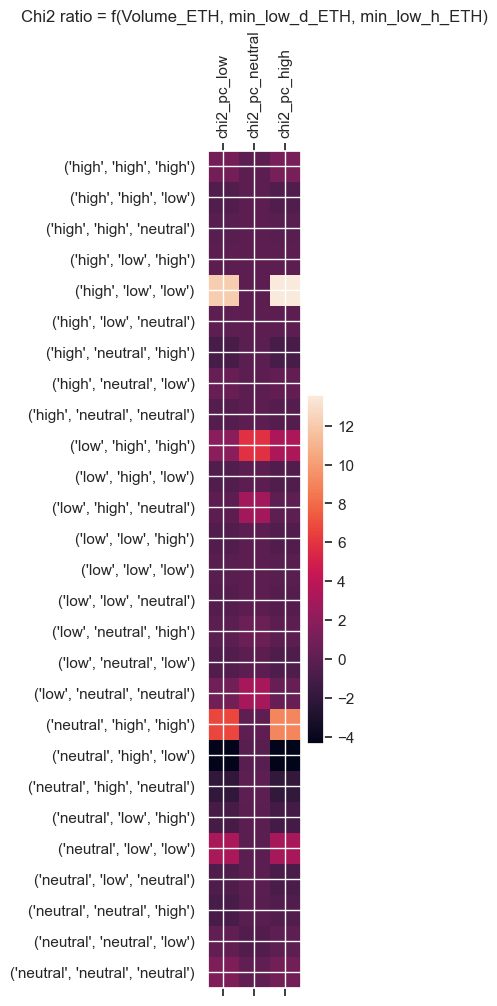

In [275]:
plot_corr(
    df_cross[["chi2_pc_low","chi2_pc_neutral","chi2_pc_high"]], 
    title = f"Chi2 ratio = f({max_chi2_last.index[0]}, {max_chi2_last.index[1]}, {max_chi2_last.index[2]})", 
    size=1.5,
)

expected:  [[ 12517.79420286  12345.85498882    480.35080831]
 [ 12546.93521683  12374.59573395    481.46904922]
 [100230.2705803   98853.54927723   3846.18014246]]
target_cat          high       low  neutral     Total
Volume_ETH_cat                                       
high             12679.0   12569.0     96.0   25344.0
low              11856.0   11570.0   1977.0   25403.0
neutral         100760.0   99435.0   2735.0  202930.0
total           125295.0  123574.0   4808.0  253677.0
xi_n =  5376.647111518828
chi2:  5376.647111518828
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


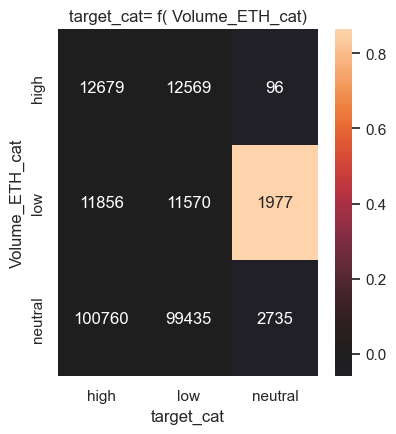

target_cat        high    low  neutral
Volume_ETH_cat                        
high             12679  12569       96
low              11856  11570     1977
neutral         100760  99435     2735

In [276]:
X = feat_name_max + "_cat"
Y = "target_cat"
plot_cont(X=X, Y=Y, data=df)

# TODO

In [ ]:
# DONE : optimize corr calculation
# DONE : evaluate value of target_14 in term of real variation % between high and low 
# DONE : cross : find cat combinaison with most prob diff between high and low (linked to chi2 not always but a little)
# TODO : change algo for target cat : buy/sell with TP/SL = 2 (if +0.1% TP => -0.05% SL)
# TODO : cross best over all lags : find cat combinaison with most prob diff between high and low (linked to chi2 ?)
# TODO : test with a 40/40/20 for feature cat : H/L/N instead of 10/10/80
# TODO : test on df_test data 
# DONE : maybe have a threshold on target instead of quantiles?
# DONE : test another target : maybe the max/min value on all targets to have ony 2 targets
# TODO : create a new exploration notebook for a target of daily trading : 
#        - find good time frame / PAST_HISTORY / FUTURE_TARGET  